In [153]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from typing import Union
from itertools import product
from utils import *

import warnings
warnings.filterwarnings('ignore')

# Traffic volume prediction

In [3]:
data = pd.read_csv('Metro_Interstate_Traffic_Volume_reduced.csv')

# Data Exploration and Preparation

In [4]:
data

date_time holiday  weather_main     weather_description  \
0      2016-07-01 00:00:00     NaN         Clear            sky is clear   
1      2016-07-01 01:00:00     NaN         Clear            sky is clear   
2      2016-07-01 02:00:00     NaN         Clear            sky is clear   
3      2016-07-01 03:00:00     NaN         Clear            sky is clear   
4      2016-07-01 04:00:00     NaN         Clear            sky is clear   
...                    ...     ...           ...                     ...   
23617  2018-09-30 19:00:00     NaN        Clouds           broken clouds   
23618  2018-09-30 20:00:00     NaN        Clouds         overcast clouds   
23619  2018-09-30 21:00:00     NaN  Thunderstorm  proximity thunderstorm   
23620  2018-09-30 22:00:00     NaN        Clouds         overcast clouds   
23621  2018-09-30 23:00:00     NaN        Clouds         overcast clouds   

       rain_1h  snow_1h  clouds_all    temp  traffic_volume  
0          0.0      0.0           1  289.04             825  
1          0.0      0.0           1  288.16             531  
2          0.0      0.0           1  286.64             381  
3          0.0      0.0           1  285.39             406  
4          0.0      0.0           1  284.67             790  
...        ...      ...         ...     ...             ...  
23617      0.0      0.0          75  283.45            3543  
23618      0.0      0.0          90  282.76            2781  
23619      0.0      0.0          90  282.73            2159  
23620      0.0      0.0          90  282.09            1450  
23621      0.0      0.0          90  282.12             954  

[23622 rows x 9 columns]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23622 entries, 0 to 23621
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date_time            23622 non-null  object 
 1   holiday              31 non-null     object 
 2   weather_main         23622 non-null  object 
 3   weather_description  23622 non-null  object 
 4   rain_1h              23622 non-null  float64
 5   snow_1h              23622 non-null  float64
 6   clouds_all           23622 non-null  int64  
 7   temp                 23622 non-null  float64
 8   traffic_volume       23622 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 1.6+ MB


As we can observe by the information of the info table, the date_time column is represented by an object. We have other three columns in strings, 'holiday', 'weather_main' and 'weather_description'. The rest of the columns are represented either by integers or floats, including the target column that in this case is a integer.
The holiday column is the only one that contains null values, being almost all of them not filled.

In [6]:
data.describe()

rain_1h  snow_1h    clouds_all          temp  traffic_volume
count  23622.000000  23622.0  23622.000000  23622.000000    23622.000000
mean       0.494697      0.0     47.238252    282.525740     3245.343282
std       63.969632      0.0     39.583571     12.400988     1959.766880
min        0.000000      0.0      0.000000    243.390000        0.000000
25%        0.000000      0.0      1.000000    273.420000     1211.000000
50%        0.000000      0.0     40.000000    284.755000     3400.000000
75%        0.000000      0.0     90.000000    292.650000     4878.000000
max     9831.300000      0.0    100.000000    310.070000     7280.000000

We noticed that the maximum amount of rain in an hour is much higher than any acceptable value. This outlier is inflating the standard deviation of the column, as all the quantiles are 0, the mean is less than 1, and the standard deviation is close to 64. Given that all quantiles (25%, 50%, 75%) are 0 and the mean is less than 1, it suggests that the vast majority of the data points have values near or at 0. The extreme value of 9831.3 distorts the overall distribution, creating a high standard deviation and making the column less reliable for analysis.

In the snow_1h column, both the minimum and maximum values are 0, meaning the column only contains a single value—0. This lack of variation makes the column completely unhelpful for predicting traffic volume. Since predictive models require features with multiple values to identify patterns, a column that only contains one value provides no useful information. Therefore, the snow_1h column should be excluded from the analysis as it cannot contribute to the prediction and we are unable to calculate accurate or variable values retrospectively, keeping this column would not be beneficial for the analysis.

The column clouds_all does not seem to have any anomalies. It represents a percentage, and all its values fall within the expected 0 to 100 range. Upon examining the summary statistics, we can see that the minimum value is 0, the maximum value is 100, and the mean is approximately 47.24. The 25th percentile (1%) and the 50th percentile (40%) are fairly close to the mean, indicating that the distribution is relatively centered around the middle. Additionally, the standard deviation (39.58) suggests moderate spread, but there are no extreme variations or outliers. The fact that the mean and second quantile values are close to each other further supports that the data is not skewed.

The temperature column does not show significant anomalies. The values range from 243.39 to 310.07, indicating a broad span of temperatures. The mean value of 282.53 is indicative of the overall central tendency, and the 25th percentile (273.42) and 50th percentile (284.76) show that the majority of the data points are clustered within a relatively narrow range between these values. The 75th percentile (292.65) indicates that most values fall below this point, with fewer observations at the higher end of the scale. The standard deviation of 12.4 suggests moderate variability, which is consistent with the observed spread of values. There are no extreme outliers, and the data appears to have a balanced distribution, as evidenced by the relatively close proximity of the mean, 25th percentile, and 50th percentile. The overall distribution is not highly skewed.

In the traffic_volume column the values range from 0 to 7280, which is the biggest interval out of all columns, excluding the outlier in the rain_1h column. Since the median is relatively closer to the third quantile than the first, we can conclude that the data is positively skewed. This claim is supported by the fact that the maximum value is much higher than the third quantile. Since the mean and the median are relatively close to each other we can conclude that the skewness of the data is not very large. The standard deviation is very high confirming a high degree of dispersion in the data.


In [7]:
data.describe(include='object')

date_time    holiday weather_main weather_description
count                 23622         31        23622               23622
unique                19608         11           11                  37
top     2018-09-20 18:00:00  Labor Day        Clear        sky is clear
freq                      5          5         7027                6268

It is visible that the date_time column has repeated values. This was not expected as the data was supposed to have continuous observations without gaps. We will deal with that later on.

Since we have 11 different holidays and only 31 rows represent a non-null value, we decided to take a look on the values since the dataset has 24 different values for each day, which means that we should have a lot more filled values. We discovered that only the first hour of the holiday was correctly filled. We will fill in the values accordingly later.

The most frequent value in the weather-main column is "Clear" appearing in almost 1/3 of the rows. We will check the different possibilities of the values.

In the weather_description column there are 37 different descriptions, with the most frequent one appearing 6268 times. Since it appears that t describes the situation presented in the previous column and given the fact that the frequency of the values are so close, we will check how these two columns correlate.


In [8]:
# Verifying if there are any missing values in the data

data.isna().sum()

date_time                  0
holiday                23591
weather_main               0
weather_description        0
rain_1h                    0
snow_1h                    0
clouds_all                 0
temp                       0
traffic_volume             0
dtype: int64

This confirms our earlier observation that the holiday column contains a significant number of null values due to the absence of a holiday on most dates. To address this, we will assign a placeholder value, such as "No holiday," to indicate that a given day does not correspond to any holiday.
On the other hand, all other columns are complete and do not contain any missing values.

In [9]:
# Assigning the new value to the holiday column

data['holiday'] = data['holiday'].fillna('No holiday')

In [10]:
# Checking if there are any duplicated values

data.duplicated().sum()

15

In [11]:
# Removing the duplicate values

data.drop_duplicates(inplace=True)

In [12]:
# Transforming the 'date_time' column to correctly represent dates and check the interval of the dataset observations

data['date_time'] = pd.to_datetime(data['date_time'])

date_min = data['date_time'].min().date()
date_max = data['date_time'].max().date()

print(f'The study dates of our project are from {date_min} to {date_max}.')

The study dates of our project are from 2016-07-01 to 2018-09-30.


Now we will address the outlier we detected earlier.

In [13]:
# Check the row of the outlier

data[data['rain_1h'] == data['rain_1h'].max()]

date_time     holiday weather_main weather_description  rain_1h  \
290 2016-07-11 17:00:00  No holiday         Rain     very heavy rain   9831.3   

     snow_1h  clouds_all    temp  traffic_volume  
290      0.0          75  302.11            5535

To substitute the value of rain with a suitable value, we will analyze the weather conditions for the corresponding day to determine an appropriate replacement.

In [14]:
# Filtering the data to show the rows of the day with the maximum rain value

filtered_data = data[data['date_time'].dt.date == pd.to_datetime('2016-07-11').date()]
filtered_data

date_time     holiday  weather_main  \
273 2016-07-11 00:00:00  No holiday        Clouds   
274 2016-07-11 01:00:00  No holiday        Clouds   
275 2016-07-11 02:00:00  No holiday        Clouds   
276 2016-07-11 03:00:00  No holiday        Clouds   
277 2016-07-11 04:00:00  No holiday        Clouds   
278 2016-07-11 05:00:00  No holiday        Clouds   
279 2016-07-11 06:00:00  No holiday          Rain   
280 2016-07-11 07:00:00  No holiday          Rain   
281 2016-07-11 08:00:00  No holiday          Rain   
282 2016-07-11 09:00:00  No holiday        Clouds   
283 2016-07-11 10:00:00  No holiday  Thunderstorm   
284 2016-07-11 11:00:00  No holiday  Thunderstorm   
285 2016-07-11 12:00:00  No holiday          Rain   
286 2016-07-11 13:00:00  No holiday  Thunderstorm   
287 2016-07-11 14:00:00  No holiday        Clouds   
288 2016-07-11 15:00:00  No holiday  Thunderstorm   
289 2016-07-11 16:00:00  No holiday  Thunderstorm   
290 2016-07-11 17:00:00  No holiday          Rain   
291 2016-07-11 18:00:00  No holiday  Thunderstorm   
292 2016-07-11 19:00:00  No holiday        Clouds   
293 2016-07-11 20:00:00  No holiday  Thunderstorm   
294 2016-07-11 21:00:00  No holiday  Thunderstorm   
295 2016-07-11 22:00:00  No holiday          Rain   
296 2016-07-11 23:00:00  No holiday  Thunderstorm   
297 2016-07-11 23:00:00  No holiday          Rain   

              weather_description  rain_1h  snow_1h  clouds_all    temp  \
273               overcast clouds     0.00      0.0          90  296.22   
274               overcast clouds     0.00      0.0          90  295.80   
275               overcast clouds     0.00      0.0          90  295.62   
276                 broken clouds     0.00      0.0          75  295.24   
277                 broken clouds     0.00      0.0          75  295.40   
278                 broken clouds     0.00      0.0          75  295.37   
279                    light rain     0.00      0.0          90  295.05   
280                    light rain     0.00      0.0          75  294.99   
281                    light rain     0.00      0.0          90  294.83   
282               overcast clouds     0.00      0.0          90  294.79   
283        proximity thunderstorm     0.00      0.0          90  295.13   
284        proximity thunderstorm     0.00      0.0          90  296.45   
285                    light rain     0.00      0.0          90  297.73   
286        proximity thunderstorm     0.00      0.0          75  299.15   
287               overcast clouds     0.00      0.0          90  300.18   
288        proximity thunderstorm     0.00      0.0          75  300.81   
289        proximity thunderstorm     0.00      0.0          75  301.48   
290               very heavy rain  9831.30      0.0          75  302.11   
291        proximity thunderstorm     0.00      0.0          75  302.54   
292                 broken clouds     0.00      0.0          75  302.39   
293                  thunderstorm     0.00      0.0          75  302.45   
294  thunderstorm with light rain     0.00      0.0          75  301.70   
295                    light rain     0.51      0.0          75  300.35   
296        proximity thunderstorm     0.00      0.0          90  299.61   
297                    light rain     0.00      0.0          90  299.61   

     traffic_volume  
273             621  
274             376  
275             291  
276             342  
277             848  
278            2780  
279            5211  
280            5803  
281            5157  
282            4016  
283            3891  
284            3998  
285            4273  
286            4475  
287            4456  
288            4858  
289            5934  
290            5535  
291            3900  
292            2856  
293            2506  
294            2062  
295            1544  
296             995  
297             995

Since no other occurrence of the day reported values on the rain_1h column, we need to find another approach to substite the value.
We will check the second largest rain value to check if both rows have similar values.

In [15]:
# Filtering the data to look for the second largest rain value

second_largest = data['rain_1h'].sort_values(ascending=False).iloc[1]
data[data['rain_1h'] == second_largest]

date_time     holiday weather_main weather_description  \
1197 2016-08-16 17:00:00  No holiday         Rain     very heavy rain   

      rain_1h  snow_1h  clouds_all    temp  traffic_volume  
1197    31.75      0.0           0  297.71            4913

Since both rows reported 'very heavy rain' under similar temperatures, we will replace the outlier value by this one.

In [16]:
# Replacing the outlier value with a suitable one

data['rain_1h'].replace(9831.3, second_largest, inplace=True)

We noticed that there are rows with the same date and time. We will check these columns to try to find a solution for them.

In [17]:
# Get duplicated dates
duplicates = data.index[data.index.duplicated(keep=False)]
unique_duplicates = data.loc[duplicates].drop_duplicates()
unique_duplicates

Empty DataFrame
Columns: [date_time, holiday, weather_main, weather_description, rain_1h, snow_1h, clouds_all, temp, traffic_volume]
Index: []

The rows have the same numerical values but report different weather conditions. Since these conditions may impact traffic in varying ways, we have decided to retain the weather condition that has the greatest potential to affect traffic, taking into account factors such as visibility, road conditions, and other relevant weather elements. We settled on the following ranking of priorities that will be assigned to every row based on the weather condition it registered. Wen encountering duplicated dates we will keep the row that has the lowest priority value and drop the rest.

In [18]:
# Define the priority order for traffic impact and drop the rows with duplicated dates

weather_impact_priority = {
    'Thunderstorm': 1, 'Snow': 2, 'Rain': 3, 
    'Drizzle': 4, 'Fog': 5, 'Haze': 6, 
    'Clouds': 7, 'Mist': 8, 'Smoke': 9, 
    'Squall': 10, 'Clear': 11
}

data['weather_priority'] = data['weather_main'].map(weather_impact_priority)

data = data.sort_values(by=['date_time', 'weather_priority'])

data = data.drop_duplicates(subset='date_time', keep='first')

data.drop(columns=['weather_priority'], inplace=True)

We also noticed that some combinations of the date and time are missing. We will create the rows and fill the missing values using the backward fill technique.

In [19]:
# Transform the date_time column into the index after creating the missing rows and filling them

data = data.set_index('date_time')

new_index = pd.date_range(start=data.index.min(), end=data.index.max(), freq='H')

data = data.reindex(new_index)

data.index.freq = 'H'

data = data.fillna(method='bfill')

Since the temperature is represented in Kelvin, we will transform it into Celsius to be interpreted easily.

In [20]:
# Converting Kelvin to Celsius

data['temp']= data['temp'] - 273.15

To address the issue of the holiday value only appearing at midnight on the respective day, we will identify all rows corresponding to holidays and propagate the holiday values throughout the entire day. Specifically, we will iterate through the dataset to find each row that represents a holiday, extract the corresponding date, and assign the holiday value to all rows matching that date.

In [21]:
# Assigning the holiday values correctly

def update_holiday(data):
    for index, row in data.iterrows():
        if row['holiday'] != 'No holiday':
            # Extract the date part from the index
            date = index.date()
            
            # Update the 'holiday' column for all rows with the same date
            data.loc[data.index.date == date, 'holiday'] = row['holiday']
            
update_holiday(data)

In [22]:
# Final look of our corrected dataset

data

holiday  weather_main     weather_description  \
2016-07-01 00:00:00  No holiday         Clear            sky is clear   
2016-07-01 01:00:00  No holiday         Clear            sky is clear   
2016-07-01 02:00:00  No holiday         Clear            sky is clear   
2016-07-01 03:00:00  No holiday         Clear            sky is clear   
2016-07-01 04:00:00  No holiday         Clear            sky is clear   
...                         ...           ...                     ...   
2018-09-30 19:00:00  No holiday        Clouds           broken clouds   
2018-09-30 20:00:00  No holiday        Clouds         overcast clouds   
2018-09-30 21:00:00  No holiday  Thunderstorm  proximity thunderstorm   
2018-09-30 22:00:00  No holiday        Clouds         overcast clouds   
2018-09-30 23:00:00  No holiday        Clouds         overcast clouds   

                     rain_1h  snow_1h  clouds_all   temp  traffic_volume  
2016-07-01 00:00:00      0.0      0.0         1.0  15.89           825.0  
2016-07-01 01:00:00      0.0      0.0         1.0  15.01           531.0  
2016-07-01 02:00:00      0.0      0.0         1.0  13.49           381.0  
2016-07-01 03:00:00      0.0      0.0         1.0  12.24           406.0  
2016-07-01 04:00:00      0.0      0.0         1.0  11.52           790.0  
...                      ...      ...         ...    ...             ...  
2018-09-30 19:00:00      0.0      0.0        75.0  10.30          3543.0  
2018-09-30 20:00:00      0.0      0.0        90.0   9.61          2781.0  
2018-09-30 21:00:00      0.0      0.0        90.0   9.58          2159.0  
2018-09-30 22:00:00      0.0      0.0        90.0   8.94          1450.0  
2018-09-30 23:00:00      0.0      0.0        90.0   8.97           954.0  

[19728 rows x 8 columns]

## Univariate Analysis

In [23]:
numerical_columns = data.select_dtypes(exclude='object').columns
categorical_columns = data.select_dtypes(include='object').columns

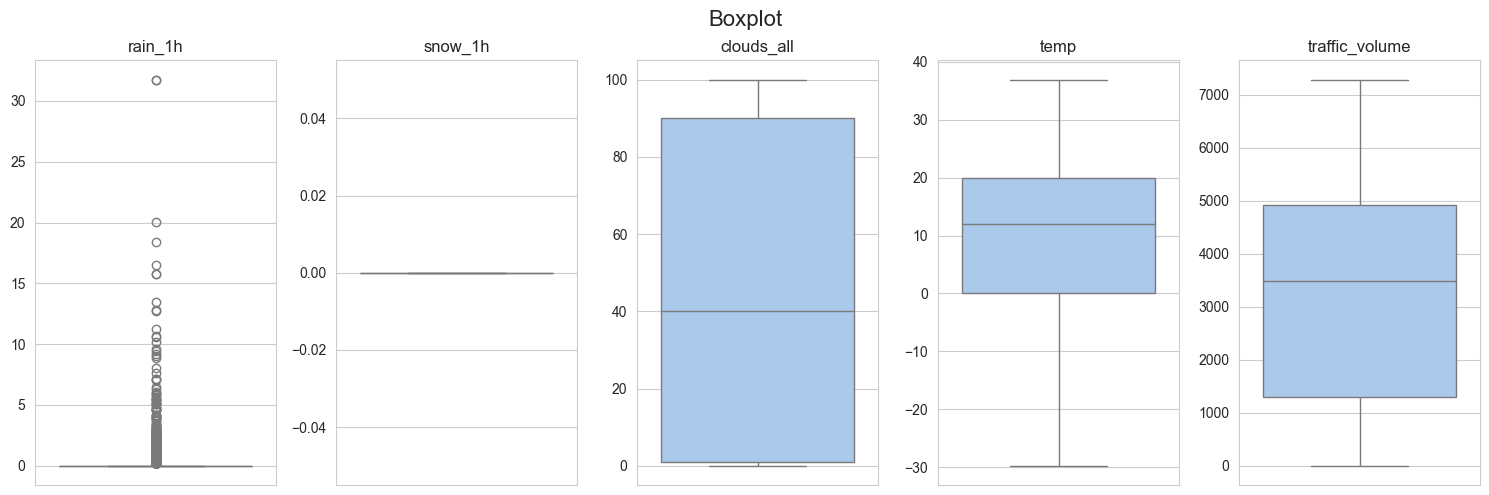

In [24]:
boxplot_visualization(data, numerical_columns, "Boxplot")

We decided to analyse the distribution of the numerical columns using boxplots.

The column rain_1h contains the majority of its values of 0, as indicated by the fact that all the quartiles of the box plot are at the 0 mark. This suggests that no rainfall is the most common condition. Additionally, a significant number of outliers can be observed, which is expected because it is rarer to have rainfall than to have none. Among these outliers, one value stands out as an extreme case, being far apart from the others. This outlier likely corresponds to an instance of extreme weather, as previously observed.

Since all the values in the snow_1h column are 0, the maximum, minimum, and all quantiles correspond to that number. As the values are constant, this column does not contain any outliers and provides no variability. Therefore, it does not offer meaningful insights or contribute to understanding the data.

We can observe that the box in the clouds_all plot is very large, which indicates that the data is spread out and exhibits high variability. The absence of outliers suggests that the extreme values are close to the interquartile range. Additionally, the slight skew in the data indicates that lower values are marginally more common than higher ones.

The box of the temp column suggests that the most frequent values fall within the 0 to 20 degrees range, with the median being close to 11°C, which can be considered a normal temperature. Since the range between the second and third quartiles is smaller than the range between the first and second quartiles, we can deduce that the upper values are more clustered than the lower ones. This is also evident from the fact that the lower extremes of temperature are further from the box than the upper extremes, indicating a slight skew toward lower temperatures. The relatively long whiskers suggests that there are some big deviations from the expected temperature values, likely due to extreme weather conditions that do not appear very often.

The last plot we can see that the data has high variability, with values ranging from 0 to nearly 7500. Since the median is close to the middle of the range, it suggests the data is fairly balanced. However, the plot also shows a slight right skew, meaning there are more lower traffic volumes than higher ones, as seen by the upper whisker extending farther from the box. This is further confirmed by the larger gap between the first and second quartiles, indicating that most traffic volume values are concentrated in the lower range, with fewer high traffic volume days.
This means that on most days, traffic volumes are relatively low, and high-traffic days are less frequent.

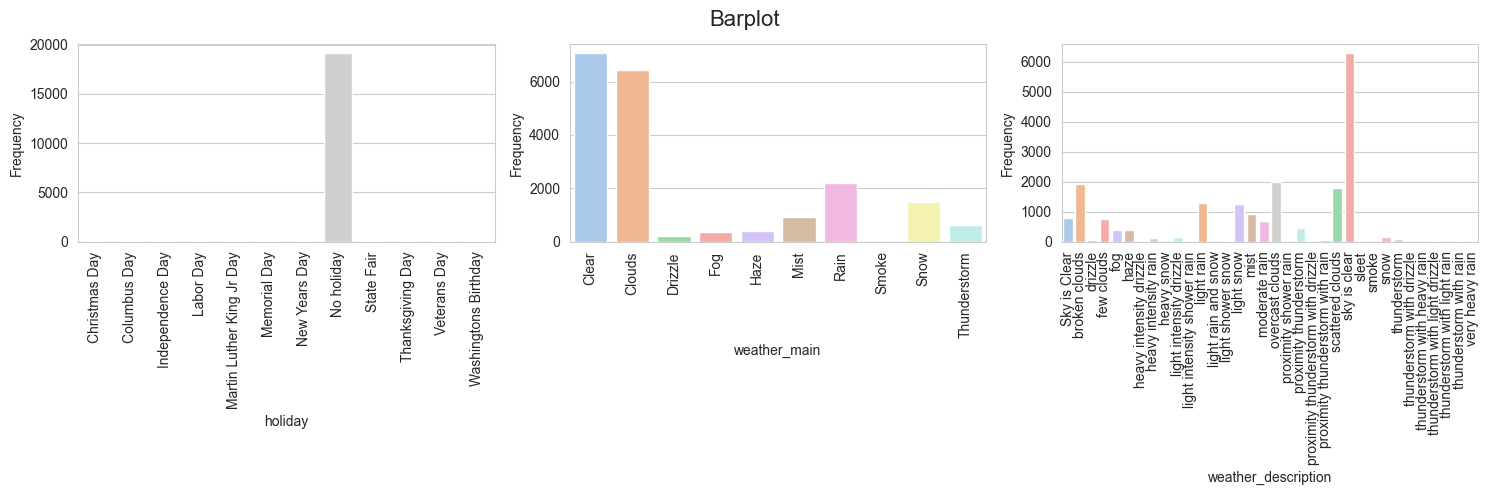

In [25]:
barplot_visualization(data, categorical_columns, "Barplot")

The barplot of the frequency of the holidays shows that 'No holiday' is by far the most frequent value. Since its frequency is so much larger than the other ones, we are unable to see the values for the other holidays. To fix this we need to make another visualization without including the 'No holiday' value.

We can observe that the most frequent weather conditions are 'Clear' and 'Clouds,' which have significantly more recorded values compared to all other options. This is expected, as mild weather conditions are typically the most common. 'Rain' appears slightly more often than the remaining weather types, while 'Smoke' has very few occurrences, making it one of the least frequent conditions. We can also conclude that the distribution is logical, as extreme weather conditions, such as 'Smoke' or 'Squall,' occur far less frequently than mild conditions like 'Clear' or 'Clouds,' which dominate the dataset.

After seeing all the possible weather conditions we noticed that a phrase is appearing twice due to an inconsistent use of capital letters. The most frequent descriptions correspond to the most frequent weather conditions: 'Sky is clear' and 'Sky is Clear' correspond to the 'Clear' weather condition and the sum of its frequencies totals the number that is visible on the previous plot. The next most frequent labels describe the 'Clouds' weather and total its frequency. The ones that appear less refer to more extreme environments that are rarer.

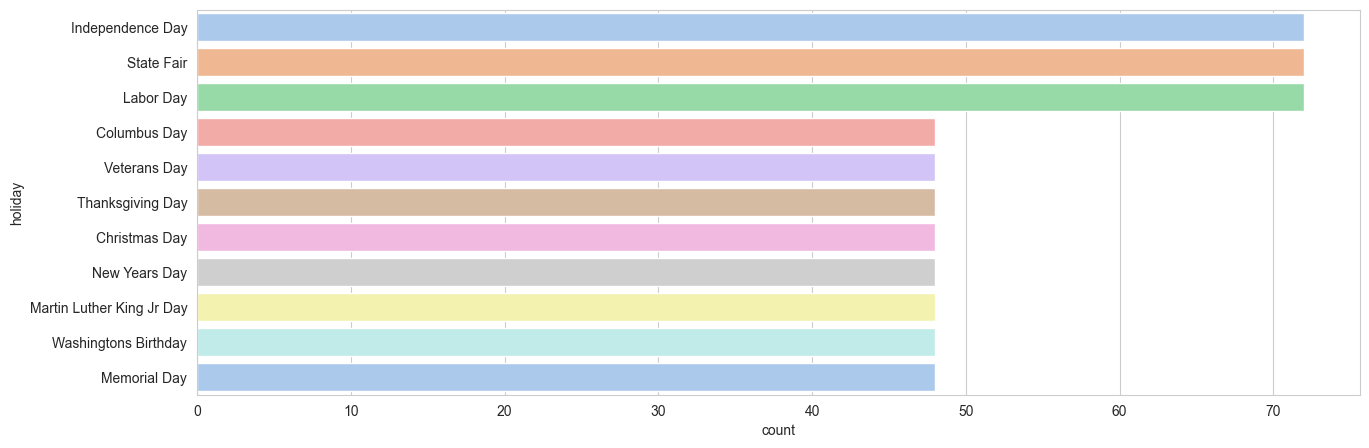

In [26]:
holidays = data.loc[data['holiday'] != 'No holiday']
plt.figure(figsize=(15,5))
sns.countplot(y='holiday', data=holidays, palette='pastel')
plt.show()

Since the dataset's time interval is approximately two years and two months it is no surprise that most of the holidays have a count of 48, meaning that they occurred two times in the study interval given the fact that the observations are made hourly. Only three holidays happened 3 times, totaling 72 registers on the dataset.

## Bivariate Analysis

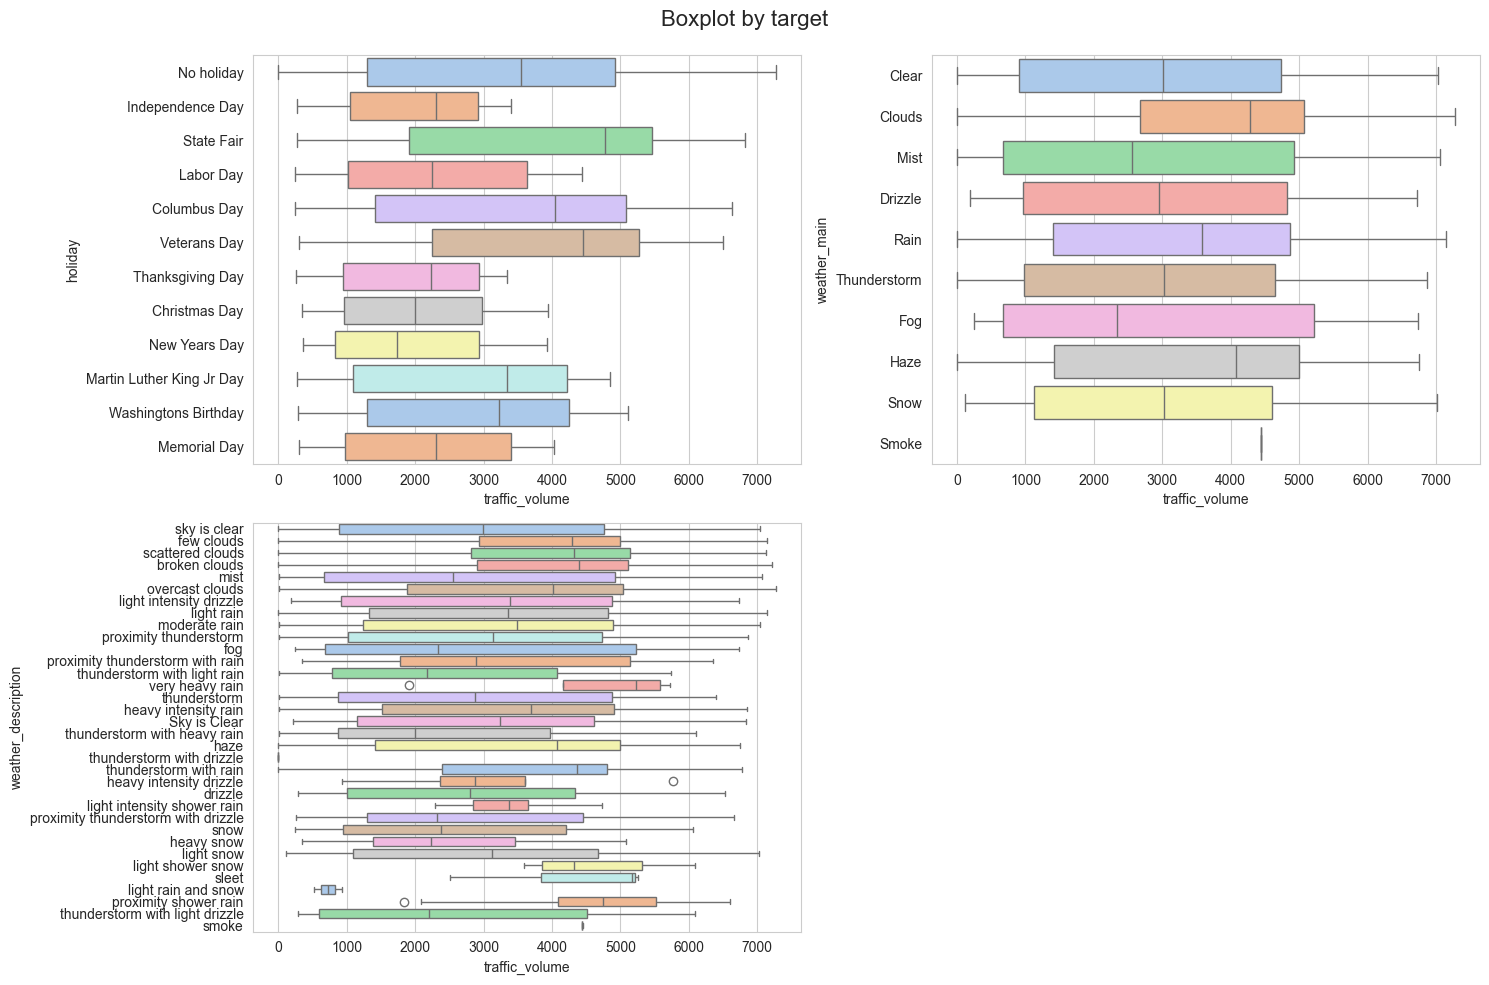

In [27]:
boxplot_by_type_visualization(data, categorical_columns, "Boxplot by target")

The first boxplot shows the distribution of the traffic volume considering each different holiday. The majority of the holidays cover a large range of numbers. No holiday, State fair, Colombus Day and Veterans Days have the highest maximums of traffic out of all holidays and also the bigger boxes with medians of 3500 and above, a high number when comparing with other holidays. Every option has similar minimums, all close to 0. Some boxes have similar values of the first quantile, median and third quantile as is the case for Independence Day, Thanksgiving, Christmas, New Years. By looking at the graph we can tell that only by this column it is not possible to narrow the traffic volume without other information, meaning that this column may not be a good predictor.

When looking at the distribution of the traffic grouping by the weather condition we can see that most of the boxes are very similar, having minimum values close to 0, and maximum ones close to 7000 and half of them has a median close to 3000. A clear exception is the 'Clouds' and 'Smoke' boxes, since the first one is very narrow compared to the others and has the highest median. The second excpetion id due to few 'Smoke' registers on the dataset that causes the quantiles to be on top of each other and the non existence of whiskers. With so few unique distributions we can say that the traffic is not only dependent on the weather since having and extreme weather does not necessarily lead to more traffic as well as having clear one does not lead to less traffic. All boxes except the last one have a bigger whisker on the higher values of traffic indicating that it is less frequent that having fewer traffic. 

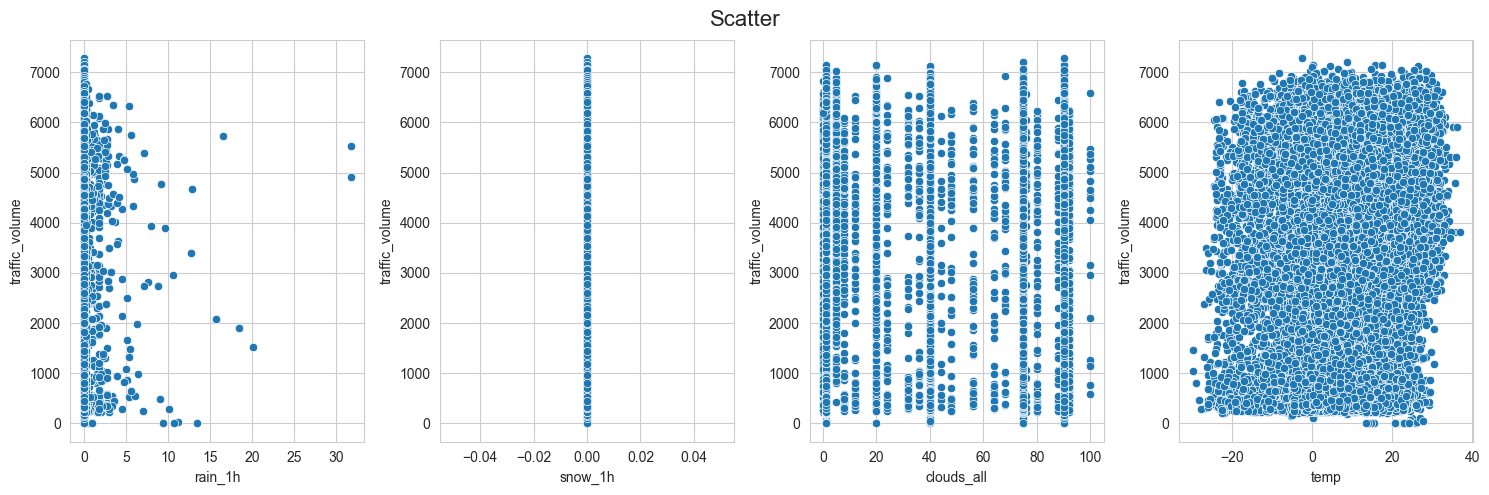

In [28]:
scatter_by_type_visualization(data, numerical_columns, title='Scatter')

Looking at the first graph we were not able to find a connection between the rain and traffic. When there is no registered rain, which happens the majority of the time, the traffic ranges from 0 to 7000. As the amount of rain increases, the amount of values decreases, havning only some occurrences, some with high traffic and some with few.

The snow graph is constant, so we will not analyse it since it does not provide any useful information.

All different values of the clouds_all and temperature columns have occurrences with high and low traffic.

We think that all the previous columns will not be good indicators of the traffic volume.

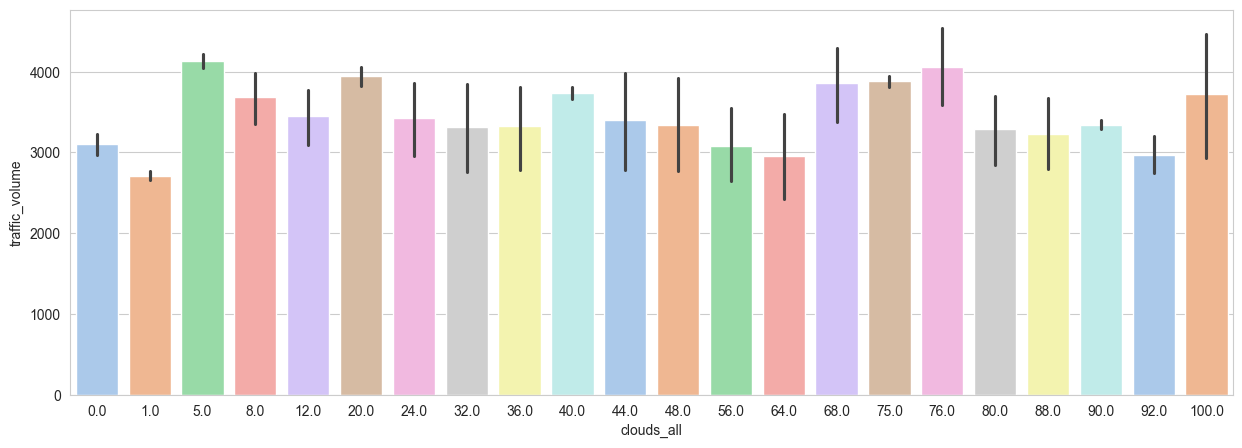

In [29]:
plt.figure(figsize=(15,5))
sns.barplot(x='clouds_all', y='traffic_volume', data=data,palette='pastel')
plt.show()

Observing the graph above we can see that different amounts of clouds tend to have different traffic volume averages. The values can range from 2800 to close to 4000. Although it seems to have a slight increase of traffic for some cloud levels, the relationship is not apparent and is likely due to the different frequency in which the values appear.

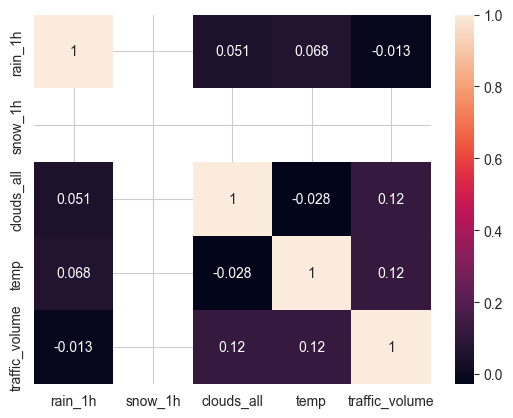

In [30]:
sns.heatmap(data.select_dtypes(include='number').corr(), annot=True)
plt.show()

using the information of the correlation matrix we were able to confirm our suspicions that the columns may not be good indicator of the traffic as they all have low correlations with the target column.

## Visualize traffic by date

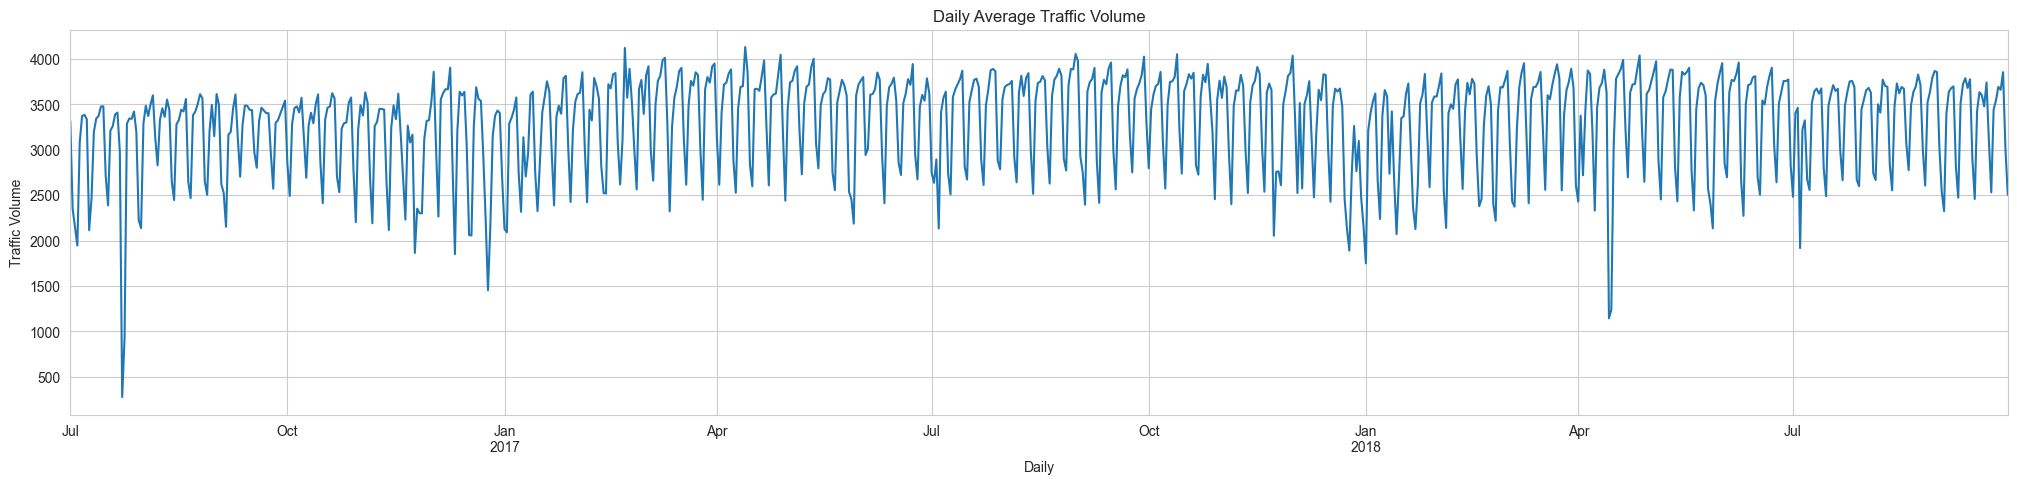

In [91]:
daily_avg = data.resample('D')['traffic_volume'].mean()

plt.figure(figsize=(25, 5))
daily_avg.plot(title='Daily Average Traffic Volume')
plt.ylabel('Traffic Volume')
plt.xlabel('Daily')
plt.show()

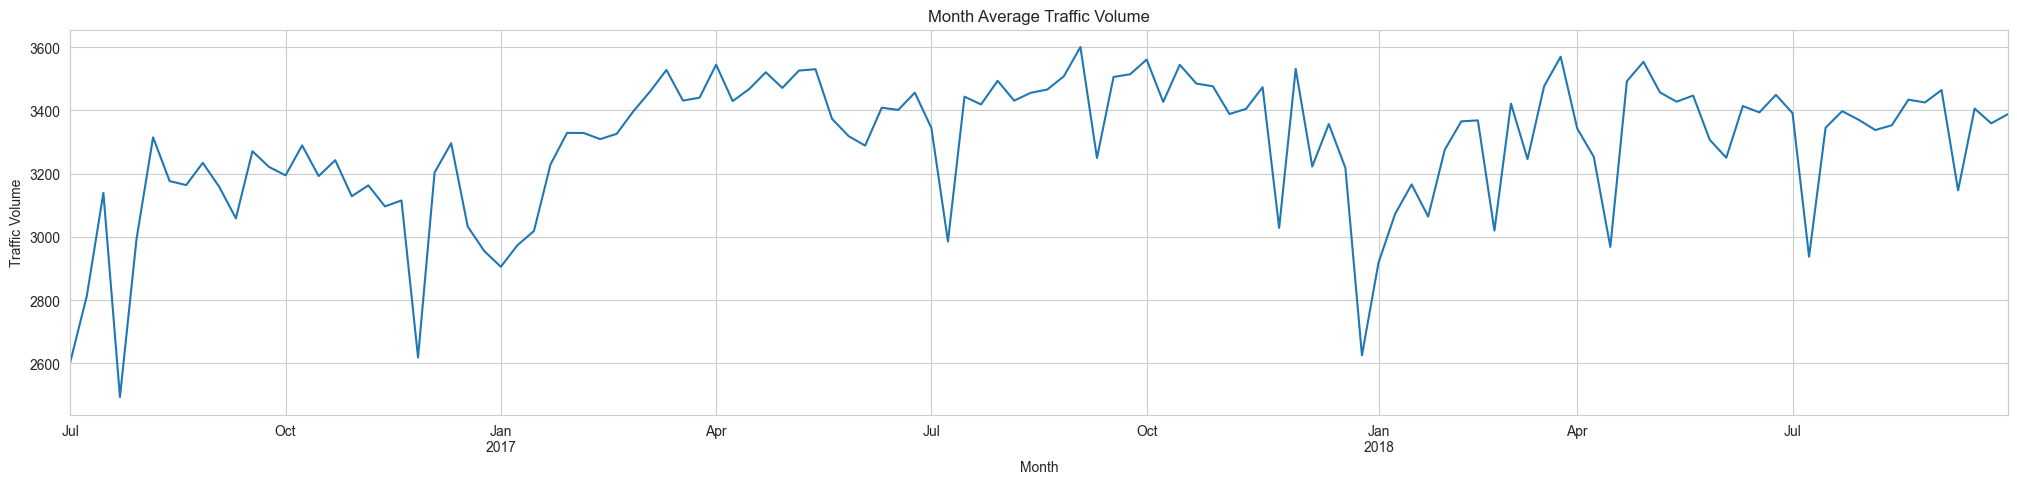

In [92]:
month_avg = data.resample('W')['traffic_volume'].mean()

plt.figure(figsize=(25, 5))
month_avg.plot(title='Month Average Traffic Volume')
plt.ylabel('Traffic Volume')
plt.xlabel('Month')
plt.show()

## Resolve inconsistencies

Independence Day : 04-07
State Fair: occore durante varios dias
Labor Day: priemria segunda feira de setembro
Columbus Day: segunda segunda feira de outubro
Veterans Day: 11-11
Thanksgiving Day: quarta quinta-feira de novembro
Christmas Day: 25-12
New Years Day: 01-01
Martin Luther King Jr Day: terceira segunda-feira de janeiro
Washingtons Birthday: Terceira segunda-feira de fevereiro.


para as datas que nunca mudao dependo do ano, vamos ver se estas estao certas.

In [38]:
data[(data['holiday'] == 'Independence Day') & ((data.index.month != 7) | (data.index.day != 4))]

Empty DataFrame
Columns: [holiday, weather_main, weather_description, rain_1h, snow_1h, clouds_all, temp, traffic_volume]
Index: []

In [39]:
data[(data['holiday'] == 'Veterans Day') & ((data.index.month != 11) | (data.index.day != 11))]

holiday weather_main weather_description  rain_1h  \
2017-11-10 00:00:00  Veterans Day        Clear        sky is clear      0.0   
2017-11-10 01:00:00  Veterans Day        Clear        sky is clear      0.0   
2017-11-10 02:00:00  Veterans Day        Clear        sky is clear      0.0   
2017-11-10 03:00:00  Veterans Day        Clear        sky is clear      0.0   
2017-11-10 04:00:00  Veterans Day        Clear        sky is clear      0.0   
2017-11-10 05:00:00  Veterans Day        Clear        sky is clear      0.0   
2017-11-10 06:00:00  Veterans Day        Clear        sky is clear      0.0   
2017-11-10 07:00:00  Veterans Day        Clear        sky is clear      0.0   
2017-11-10 08:00:00  Veterans Day        Clear        sky is clear      0.0   
2017-11-10 09:00:00  Veterans Day       Clouds       broken clouds      0.0   
2017-11-10 10:00:00  Veterans Day       Clouds       broken clouds      0.0   
2017-11-10 11:00:00  Veterans Day         Haze                haze      0.0   
2017-11-10 12:00:00  Veterans Day        Clear        sky is clear      0.0   
2017-11-10 13:00:00  Veterans Day        Clear        sky is clear      0.0   
2017-11-10 14:00:00  Veterans Day       Clouds     overcast clouds      0.0   
2017-11-10 15:00:00  Veterans Day       Clouds    scattered clouds      0.0   
2017-11-10 16:00:00  Veterans Day       Clouds     overcast clouds      0.0   
2017-11-10 17:00:00  Veterans Day       Clouds     overcast clouds      0.0   
2017-11-10 18:00:00  Veterans Day       Clouds     overcast clouds      0.0   
2017-11-10 19:00:00  Veterans Day       Clouds     overcast clouds      0.0   
2017-11-10 20:00:00  Veterans Day         Snow          light snow      0.0   
2017-11-10 21:00:00  Veterans Day         Snow          light snow      0.0   
2017-11-10 22:00:00  Veterans Day         Snow                snow      0.0   
2017-11-10 23:00:00  Veterans Day         Snow          light snow      0.0   

                     snow_1h  clouds_all   temp  traffic_volume  
2017-11-10 00:00:00      0.0         1.0 -11.47           812.0  
2017-11-10 01:00:00      0.0         1.0 -11.67           418.0  
2017-11-10 02:00:00      0.0         1.0 -11.79           311.0  
2017-11-10 03:00:00      0.0         1.0 -12.07           419.0  
2017-11-10 04:00:00      0.0         1.0 -12.00           776.0  
2017-11-10 05:00:00      0.0         1.0 -12.20          2725.0  
2017-11-10 06:00:00      0.0         1.0 -11.64          5554.0  
2017-11-10 07:00:00      0.0         1.0 -10.92          6494.0  
2017-11-10 08:00:00      0.0         1.0 -10.87          5593.0  
2017-11-10 09:00:00      0.0        75.0 -10.20          5039.0  
2017-11-10 10:00:00      0.0        75.0  -8.87          4584.0  
2017-11-10 11:00:00      0.0        40.0  -7.93          4964.0  
2017-11-10 12:00:00      0.0         1.0  -7.34          5106.0  
2017-11-10 13:00:00      0.0         1.0  -6.72          5445.0  
2017-11-10 14:00:00      0.0        90.0  -6.29          5311.0  
2017-11-10 15:00:00      0.0        40.0  -5.72          5667.0  
2017-11-10 16:00:00      0.0        90.0  -5.29          6057.0  
2017-11-10 17:00:00      0.0        90.0  -5.00          5412.0  
2017-11-10 18:00:00      0.0        90.0  -4.60          4707.0  
2017-11-10 19:00:00      0.0        90.0  -4.34          3505.0  
2017-11-10 20:00:00      0.0        90.0  -3.93          3025.0  
2017-11-10 21:00:00      0.0        90.0  -3.65          2836.0  
2017-11-10 22:00:00      0.0        90.0  -3.92          2467.0  
2017-11-10 23:00:00      0.0        90.0  -4.36          1739.0

como o dia esta mal marcado iremos alterara para a data certa

In [40]:
date = pd.to_datetime('2017-11-10').date()
data.loc[data.index.date == date, 'holiday'] = 'No holiday'

date = pd.to_datetime('2017-11-11').date()
data.loc[data.index.date == date, 'holiday'] = 'Veterans Day'

In [41]:
data[(data['holiday'] == 'Christmas Day') & ((data.index.month != 12) | (data.index.day != 25))]

holiday weather_main      weather_description  \
2016-12-26 00:00:00  Christmas Day         Rain               light rain   
2016-12-26 01:00:00  Christmas Day       Clouds          overcast clouds   
2016-12-26 02:00:00  Christmas Day       Clouds               few clouds   
2016-12-26 03:00:00  Christmas Day      Drizzle  light intensity drizzle   
2016-12-26 04:00:00  Christmas Day       Clouds            broken clouds   
2016-12-26 05:00:00  Christmas Day       Clouds          overcast clouds   
2016-12-26 06:00:00  Christmas Day       Clouds          overcast clouds   
2016-12-26 07:00:00  Christmas Day       Clouds          overcast clouds   
2016-12-26 08:00:00  Christmas Day         Snow               light snow   
2016-12-26 09:00:00  Christmas Day         Snow               light snow   
2016-12-26 10:00:00  Christmas Day         Snow               light snow   
2016-12-26 11:00:00  Christmas Day         Snow               light snow   
2016-12-26 12:00:00  Christmas Day         Snow               light snow   
2016-12-26 13:00:00  Christmas Day         Snow               light snow   
2016-12-26 14:00:00  Christmas Day         Snow        light shower snow   
2016-12-26 15:00:00  Christmas Day         Snow        light shower snow   
2016-12-26 16:00:00  Christmas Day         Snow               light snow   
2016-12-26 17:00:00  Christmas Day         Snow               light snow   
2016-12-26 18:00:00  Christmas Day         Snow               light snow   
2016-12-26 19:00:00  Christmas Day         Snow               light snow   
2016-12-26 20:00:00  Christmas Day         Snow               light snow   
2016-12-26 21:00:00  Christmas Day         Snow               light snow   
2016-12-26 22:00:00  Christmas Day         Snow               light snow   
2016-12-26 23:00:00  Christmas Day         Snow               light snow   

                     rain_1h  snow_1h  clouds_all  temp  traffic_volume  
2016-12-26 00:00:00      0.0      0.0        90.0  2.93           732.0  
2016-12-26 01:00:00      0.0      0.0        90.0  3.21           508.0  
2016-12-26 02:00:00      0.0      0.0        20.0  4.00           431.0  
2016-12-26 03:00:00      0.0      0.0        90.0  4.31           440.0  
2016-12-26 04:00:00      0.0      0.0        75.0  3.15           804.0  
2016-12-26 05:00:00      0.0      0.0        90.0  0.69          1173.0  
2016-12-26 06:00:00      0.0      0.0        90.0 -0.71          1931.0  
2016-12-26 07:00:00      0.0      0.0        90.0 -2.56          1978.0  
2016-12-26 08:00:00      0.0      0.0        90.0 -3.86          1364.0  
2016-12-26 09:00:00      0.0      0.0        90.0 -5.57          1962.0  
2016-12-26 10:00:00      0.0      0.0        90.0 -6.30          2476.0  
2016-12-26 11:00:00      0.0      0.0        90.0 -6.31          2967.0  
2016-12-26 12:00:00      0.0      0.0        90.0 -6.22          3374.0  
2016-12-26 13:00:00      0.0      0.0        90.0 -6.00          3730.0  
2016-12-26 14:00:00      0.0      0.0        90.0 -6.26          3921.0  
2016-12-26 15:00:00      0.0      0.0        90.0 -6.72          3946.0  
2016-12-26 16:00:00      0.0      0.0        90.0 -6.69          3798.0  
2016-12-26 17:00:00      0.0      0.0        90.0 -6.88          3625.0  
2016-12-26 18:00:00      0.0      0.0        90.0 -7.12          3295.0  
2016-12-26 19:00:00      0.0      0.0        90.0 -7.20          2739.0  
2016-12-26 20:00:00      0.0      0.0        90.0 -7.60          2141.0  
2016-12-26 21:00:00      0.0      0.0        90.0 -7.54          2024.0  
2016-12-26 22:00:00      0.0      0.0        90.0 -7.47          1519.0  
2016-12-26 23:00:00      0.0      0.0        90.0 -7.40           964.0

In [42]:
date = pd.to_datetime('2016-12-26').date()
data.loc[data.index.date == date, 'holiday'] = 'No holiday'

date = pd.to_datetime('2016-12-25').date()
data.loc[data.index.date == date, 'holiday'] = 'Christmas Day'

In [43]:
data[(data['holiday'] == 'New Years Day') & ((data.index.month != 1) | (data.index.day != 1))]

holiday weather_main weather_description  rain_1h  \
2017-01-02 00:00:00  New Years Day         Snow          light snow      0.0   
2017-01-02 01:00:00  New Years Day         Snow          light snow      0.0   
2017-01-02 02:00:00  New Years Day         Snow          light snow      0.0   
2017-01-02 03:00:00  New Years Day         Snow          light snow      0.0   
2017-01-02 04:00:00  New Years Day       Clouds     overcast clouds      0.0   
2017-01-02 05:00:00  New Years Day       Clouds     overcast clouds      0.0   
2017-01-02 06:00:00  New Years Day       Clouds     overcast clouds      0.0   
2017-01-02 07:00:00  New Years Day       Clouds     overcast clouds      0.0   
2017-01-02 08:00:00  New Years Day       Clouds     overcast clouds      0.0   
2017-01-02 09:00:00  New Years Day       Clouds     overcast clouds      0.0   
2017-01-02 10:00:00  New Years Day         Snow          light snow      0.0   
2017-01-02 11:00:00  New Years Day         Snow          light snow      0.0   
2017-01-02 12:00:00  New Years Day         Snow          light snow      0.0   
2017-01-02 13:00:00  New Years Day         Snow          light snow      0.0   
2017-01-02 14:00:00  New Years Day         Snow          light snow      0.0   
2017-01-02 15:00:00  New Years Day         Snow          light snow      0.0   
2017-01-02 16:00:00  New Years Day         Snow          light snow      0.0   
2017-01-02 17:00:00  New Years Day         Snow          light snow      0.0   
2017-01-02 18:00:00  New Years Day         Snow          light snow      0.0   
2017-01-02 19:00:00  New Years Day         Mist                mist      0.0   
2017-01-02 20:00:00  New Years Day         Snow          light snow      0.0   
2017-01-02 21:00:00  New Years Day         Snow          light snow      0.0   
2017-01-02 22:00:00  New Years Day         Snow          light snow      0.0   
2017-01-02 23:00:00  New Years Day         Snow          light snow      0.0   

                     snow_1h  clouds_all  temp  traffic_volume  
2017-01-02 00:00:00      0.0        90.0 -2.53           798.0  
2017-01-02 01:00:00      0.0        90.0 -2.60           522.0  
2017-01-02 02:00:00      0.0        90.0 -2.66           457.0  
2017-01-02 03:00:00      0.0        90.0 -2.73           363.0  
2017-01-02 04:00:00      0.0        90.0 -2.66           508.0  
2017-01-02 05:00:00      0.0        90.0 -2.66           849.0  
2017-01-02 06:00:00      0.0        90.0 -2.53          1562.0  
2017-01-02 07:00:00      0.0        90.0 -2.33          1792.0  
2017-01-02 08:00:00      0.0        90.0 -2.27          2014.0  
2017-01-02 09:00:00      0.0        90.0 -1.60          2401.0  
2017-01-02 10:00:00      0.0        90.0 -1.50          2832.0  
2017-01-02 11:00:00      0.0        90.0 -0.93          3470.0  
2017-01-02 12:00:00      0.0        90.0 -0.88          3732.0  
2017-01-02 13:00:00      0.0        90.0 -0.73          3750.0  
2017-01-02 14:00:00      0.0        90.0 -0.56          3933.0  
2017-01-02 15:00:00      0.0        90.0 -0.44          3762.0  
2017-01-02 16:00:00      0.0        90.0 -0.44          3563.0  
2017-01-02 17:00:00      0.0        90.0 -0.13          3261.0  
2017-01-02 18:00:00      0.0        90.0 -0.13          2875.0  
2017-01-02 19:00:00      0.0        90.0 -0.20          2244.0  
2017-01-02 20:00:00      0.0        90.0 -0.20          1785.0  
2017-01-02 21:00:00      0.0        90.0 -0.20          1660.0  
2017-01-02 22:00:00      0.0        90.0 -0.20          1226.0  
2017-01-02 23:00:00      0.0        90.0 -0.13           827.0

In [44]:
date = pd.to_datetime('2017-01-02').date()
data.loc[data.index.date == date, 'holiday'] = 'No holiday'

date = pd.to_datetime('2017-01-01').date()
data.loc[data.index.date == date, 'holiday'] = 'New Years Day'

## Encoding data

In [46]:
label_encoder = LabelEncoder()
data_encoded = data.copy()
for col in data.select_dtypes(include='object').columns:
    data_encoded[col] = label_encoder.fit_transform(data[col])

In [47]:
data_encoded.drop(columns= ['snow_1h'], inplace=True)

## Stationary

In [48]:
result = adfuller(data_encoded['traffic_volume'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] > 0.05:
    print('not stationary')
else:
    print('stationary')
print(f'Número de lags utilizados: {result[2]}')


ADF Statistic: -17.688426491080936
p-value: 3.581450520708116e-30
stationary
Número de lags utilizados: 45


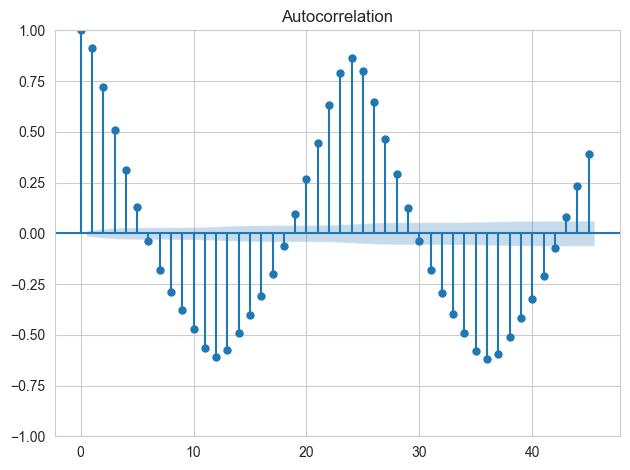

In [49]:
traffic_volume = data_encoded['traffic_volume']
plot_acf(traffic_volume, lags=45)
plt.tight_layout()

The plot shows a significant sinusoidal pattern with a periodicity, indicating strong seasonal behavior. The slow decay in the autocorrelations suggests a non-stationary series with periodic fluctuations.

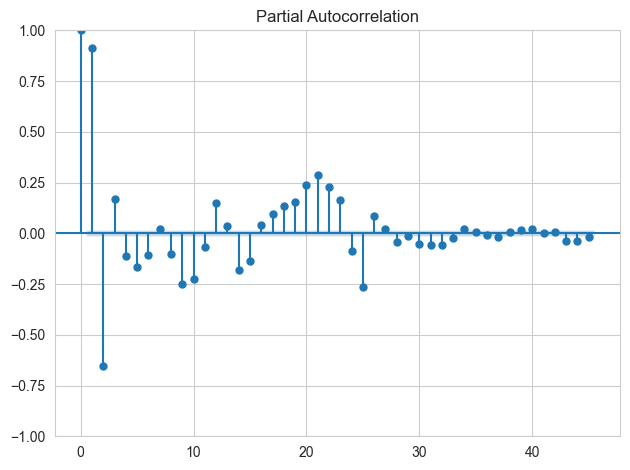

In [50]:
plot_pacf(traffic_volume, lags=45)
plt.tight_layout()

# Create Models

## Statistical Models


### Baseline models

In [171]:
train = traffic_volume[:-72]
test = traffic_volume[-72:]
test = test.to_frame()

In [172]:
def mean(df,train_len, horizon, window):
    
    total_len = train_len + horizon
    
    pred_mean = []
    
    for i in range(train_len,total_len, window):
        mean = np.mean(df[:i].values)
        pred_mean.extend(mean for _ in range(window))
        
    return pred_mean

In [173]:
def last(df,train_len, horizon, window):
    total_len = train_len + horizon
    
    pred_last_value = []
        
    for i in range(train_len,total_len, window):
        last_value = df[:i].iloc[-1]
        pred_last_value.extend(last_value for _ in range(window))
    return pred_last_value

### ARMA

iremos usar o modelo arma uma vez que nao conseguimos

In [53]:
def optimize_ARMA(data, order_list):
    results = []
    for order in order_list:
        try:
            model = SARIMAX(data, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [180]:

ps = range(0,6, 1)
qs = range(0,29, 1)
order_list = list(product(ps,qs))

result = optimize_ARMA(train, order_list)
result

(p,q)            AIC
0    (5, 28)  299771.621690
1    (5, 27)  299837.561641
2    (4, 26)  299851.930879
3    (5, 25)  299854.066423
4    (5, 26)  299868.248848
..       ...            ...
169  (0, 27)  358954.737457
170  (0, 22)  358977.240773
171  (0, 25)  359002.319403
172  (0, 19)  359695.759912
173   (0, 0)  380144.560880

[174 rows x 2 columns]

                               SARIMAX Results                                
Dep. Variable:         traffic_volume   No. Observations:                19656
Model:              SARIMAX(5, 0, 28)   Log Likelihood             -149851.811
Date:                Sat, 21 Dec 2024   AIC                         299771.622
Time:                        08:42:50   BIC                         300039.750
Sample:                    07-01-2016   HQIC                        299859.419
                         - 09-27-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9382      0.102     18.988      0.000       1.738       2.138
ar.L2         -1.7863      0.236     -7.553      0.000      -2.250      -1.323
ar.L3          1.6093      0.275      5.860      0.0

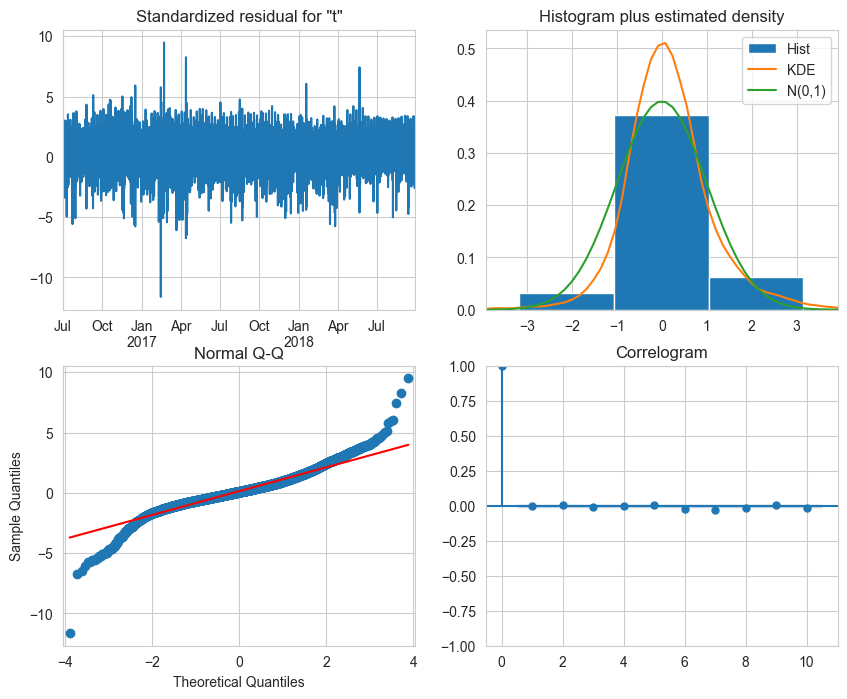

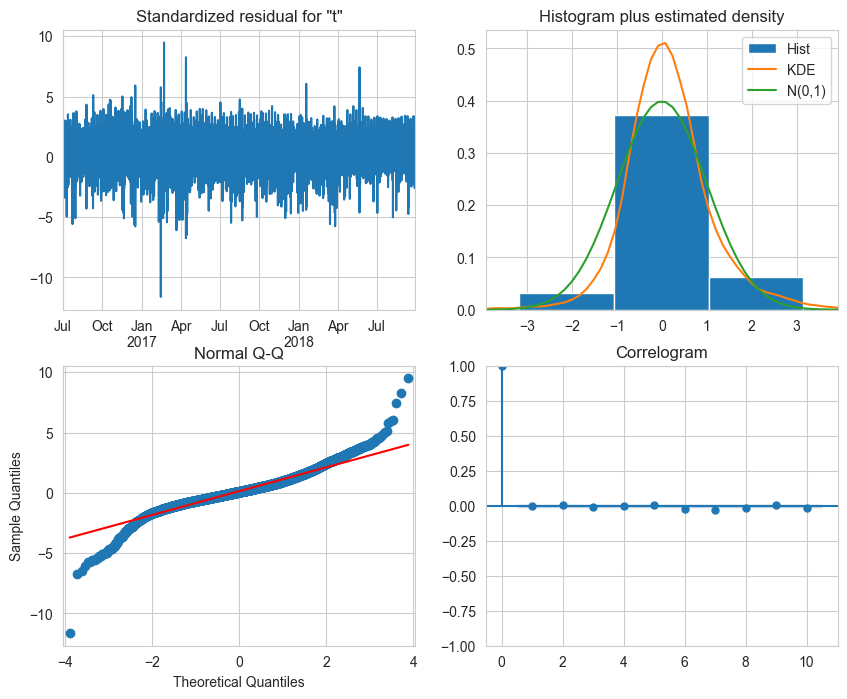

In [56]:
model = SARIMAX(train, order=(5,0,28),simple_differencing=False)

model_fit = model.fit(disp=False)

print(model_fit.summary())

model_fit.plot_diagnostics(figsize=(10,8))

In [57]:
def arma(df,train_len, horizon, window):
    
    total_len = train_len + horizon
    pred_arma = []
    
    for i in range(train_len,total_len, window):
        model = SARIMAX(df[:i], order=(3,0,3))
        res = model.fit(disp=False)
        predictions = res.get_prediction(0,i+ window -1)
        oos_pred = predictions.predicted_mean.iloc[-window]
        pred_arma.extend(oos_pred for _ in range(window))
    return pred_arma

### SARIMA

In [176]:
def optimize_SARIMA(data: Union[pd.Series, list], order_list: list, d: int, D: int, s: int):
    results = []

    for order in order_list:
        try:
            model = SARIMAX(
                data,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False
            ).fit(disp=False)
            aic = model.aic
            results.append([order[0], order[1], order[2], order[3], aic])
        except Exception as e:
            continue

    result_df = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'AIC'])
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [177]:
#Sarima(p,d,q)(P,D,Q)m
#d = 0, s=24, D = 0

# SARIMA parameters
d = 0
D = 0
s = 24

ps = [0, 1, 2]
qs = [0, 1, 2]
Ps = [0, 1, 2]
Qs = [0, 1, 2]

parameters_sarima = list(product(ps, qs, Ps, Qs))

In [ ]:
result = optimize_SARIMA(data=train.values, order_list=parameters_sarima, d=d, D=D, s=s)
result

In [ ]:
def sarima(df,train_len, horizon, window):
    
    total_len = train_len + horizon
    pred_sarima = []
    
    for i in range(train_len,total_len, window):
        model = SARIMAX(df[:i], order=(0, 0, 0), seasonal_order=(0, 0, 0, 24))
        res = model.fit(disp=False)
        
        predictions = res.get_prediction(0,i+ window -1)
        oos_pred = predictions.predicted_mean.iloc[-window]
        
        pred_arma.extend(oos_pred for _ in range(window))
    return pred_sarima

### SARIMAX

In [ ]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 12

pred_ARMA = arma(traffic_volume, TRAIN_LEN, HORIZON, WINDOW)
pred_last_value = last(traffic_volume, TRAIN_LEN, HORIZON, WINDOW)
pred_mean = mean(traffic_volume, TRAIN_LEN, HORIZON, WINDOW)
pred_sarima = arma(traffic_volume, TRAIN_LEN, HORIZON, WINDOW)

test.loc[:, 'pred_ARMA'] = pred_ARMA
test.loc[:, 'pred_SARIMA'] = pred_sarima
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_mean'] = pred_mean

In [93]:

mse_mean = mean_squared_error(test['traffic_volume'], test['pred_mean'])
mse_last = mean_squared_error(test['traffic_volume'], test['pred_last_value'])
mse_arma = mean_squared_error(test['traffic_volume'], test['pred_ARMA'])
mse_sarima = mean_squared_error(test['traffic_volume'], test['pred_SARIMA'])

mae_mean = mean_absolute_error(test['traffic_volume'], test['pred_mean'])
mae_last = mean_absolute_error(test['traffic_volume'], test['pred_last_value'])
mae_arma = mean_absolute_error(test['traffic_volume'], test['pred_ARMA'])
mae_sarima = mean_absolute_error(test['traffic_volume'], test['pred_SARIMA'])

print(f'Historical Mean, MSE:{round(mse_mean, 3)} and MAE {round(mae_mean, 3)}')
print(f'Last Value, MSE:{round(mse_last, 3)} and MAE {round(mae_last, 3)}')
print(f'ARMA, MSE:{round(mse_arma, 3)} and MAE {round(mae_arma, 3)}')
print(f'SARIMA, MSE:{round(mse_sarima, 3)} and MAE {round(mae_sarima, 3)}')

KeyError: 'pred_mean'

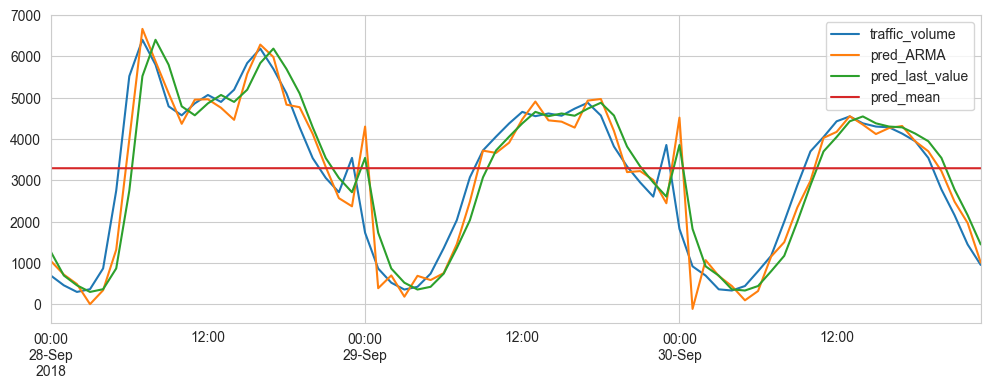

In [61]:
plt.rcParams['figure.figsize'] = [12,4]
test.plot()
plt.show()

## Machine Learning Models

In [113]:
results_ml_val = pd.DataFrame(columns=['Model', 'Horizon','MAE', 'MSE', 'R2', 'RMSE'])
results_ml_test = pd.DataFrame(columns=['Model', 'Horizon', 'MAE', 'MSE', 'R2', 'RMSE'])

### Split the data

In [114]:
len_train = int(len(data_encoded) * 0.7)
len_val = int(len(data_encoded) * 0.15)
len_test = len(data_encoded) - len_train - len_val

train = data_encoded[:len_train]
val = data_encoded[len_train:len_train + len_val]
test = data_encoded[len_train + len_val:]

print(f"Train size: {len(train)}")
print(f"Validation size: {len(val)}")
print(f"Test size: {len(test)}")

Train size: 13809
Validation size: 2959
Test size: 2960


### Scaling the data

In [115]:
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
test_scaled = scaler.transform(test)

train_scaled_df = pd.DataFrame(train_scaled, index=train.index, columns=train.columns)
val_scaled_df = pd.DataFrame(val_scaled, index=val.index, columns=val.columns)
test_scaled_df = pd.DataFrame(test_scaled, index=test.index, columns=test.columns)

In [116]:
target_min = scaler.data_min_[-1]
target_max = scaler.data_max_[-1]

In [117]:
def inverse_transform(predictions, target_min, target_max):
    return predictions * (target_max - target_min) + target_min

### Window 

#### Single-step forecast

In [118]:
models = {
    "Linear Regression": LinearRegression(),
    "KNeighbors Regressor": KNeighborsRegressor(),
    "Support Vector Regression": SVR(),
    "Bagging Regressor": BaggingRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
}

In [119]:
WINDOW_IN = 12
HORIZON = 1    

train_windowed = slideWindow(train_scaled_df[['traffic_volume']], WINDOW_IN, HORIZON)
val_windowed = slideWindow(val_scaled_df[['traffic_volume']], WINDOW_IN, HORIZON)
test_windowed = slideWindow(test_scaled_df[['traffic_volume']], WINDOW_IN, HORIZON)

X_train = train_windowed.iloc[:, :-HORIZON].values  
y_train = train_windowed.iloc[:, -HORIZON:].values 

X_val = val_windowed.iloc[:, :-HORIZON].values
y_val = val_windowed.iloc[:, -HORIZON:].values

X_test = test_windowed.iloc[:, :-HORIZON].values
y_test = test_windowed.iloc[:, -HORIZON:].values

##### Train and evaluate the models

In [120]:
for name, model in models.items():
    model.fit(X_train, y_train) 
    
    y_val_pred = model.predict(X_val)
    
    y_val_pred = inverse_transform(y_val_pred, target_min, target_max)
    y_val_transformed = inverse_transform(y_val, target_min, target_max)
    
    mae = mean_absolute_error(y_val_transformed, y_val_pred)
    mse = mean_squared_error(y_val_transformed, y_val_pred)
    r2 = r2_score(y_val_transformed, y_val_pred)
    rmse = np.sqrt(mse)
    
    
    add_results(results_ml_val, name, HORIZON, mae, mse, r2, rmse)
    
results_ml_val

Model  Horizon         MAE            MSE        R2  \
0          Linear Regression        1  391.313963  274802.696198  0.933283   
1       KNeighbors Regressor        1  202.542111  103651.230322  0.974835   
2  Support Vector Regression        1  333.399894  162377.905241  0.960577   
3          Bagging Regressor        1  182.430268   76589.793831  0.981405   
4          Gradient Boosting        1  207.050198   94437.700159  0.977072   
5              Decision Tree        1  248.049881  157060.119104  0.961869   
6              Random Forest        1  174.955633   71723.701765  0.982587   

         RMSE  
0  524.216269  
1  321.949111  
2  402.961419  
3  276.748611  
4  307.307176  
5  396.308111  
6  267.812811

Linear regressions has the lowest R squared score with 93.3%, showing that it struggled making right predictions when comparing with another models.

KNN outperforms the Linear Regression model having less error metrics and a higher R squared score.

SVR performs worse than the previous model, showing that it could not capture the complexity of the data as well as some other models.

Bagging Regressor got the second highest R squared score and low errors, showing that it is a strong contender when it comes to predicting the traffic volume.

Gradient Boosting is slightly outdone by KNN and demonstrates to be a good alternative.

Decision Tree is able to capture the data patterns better than the simpler model, Linear Regression. It has low performance when compared to the rest of the models.

Random Forest was the best performing model. This ensemble model got the highest R squared score and the lowest errors out of all models we tested.

In [121]:
for name, model in models.items():
    model.fit(X_train, y_train) 
    y_test_pred = model.predict(X_test) 


    y_test_pred = inverse_transform(y_test_pred, target_min, target_max)
    y_test_transformed = inverse_transform(y_test, target_min, target_max)
    
    mae = mean_absolute_error(y_test_transformed, y_test_pred)
    mse = mean_squared_error(y_test_transformed, y_test_pred)
    r2 = r2_score(y_test_transformed, y_test_pred)
    rmse = np.sqrt(mse)

    add_results(results_ml_test, name, HORIZON, mae, mse, r2, rmse)
    
results_ml_test

Model  Horizon         MAE            MSE        R2  \
0          Linear Regression        1  348.044764  228739.996312  0.938877   
1       KNeighbors Regressor        1  166.298304   59867.571872  0.984002   
2  Support Vector Regression        1  279.116834  115475.188998  0.969143   
3          Bagging Regressor        1  158.737280   55703.599291  0.985115   
4          Gradient Boosting        1  179.708965   68485.210084  0.981700   
5              Decision Tree        1  225.170624  118952.650271  0.968214   
6              Random Forest        1  147.144172   48444.585847  0.987055   

         RMSE  
0  478.267704  
1  244.678507  
2  339.816405  
3  236.016100  
4  261.696790  
5  344.895129  
6  220.101308

##### Hyperparameters

In [467]:
param_grids = {
    "Linear Regression": {
        "fit_intercept": [True, False]
    },
    "KNeighbors Regressor": {
        "n_neighbors": [3],
        "weights": ["uniform", "distance"],
        "algorithm": ["auto", "ball_tree", "kd_tree"],
        "p": [1, 2]  
    },
    "Support Vector Regression": {
        "C": [0.1, 1, 10],
        "epsilon": [0.01, 0.1, 0.5],
        "kernel": ["linear", "rbf"],
        "gamma": ["scale", "auto"]
    },
    "Bagging Regressor": {
        "n_estimators": [10, 50, 100],
        "max_samples": [0.5, 0.8, 1.0],
        "bootstrap": [True, False],
        "bootstrap_features": [True, False]
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 10],
        "subsample": [0.8, 1.0]
    },
    "Decision Tree": {
        "max_depth": [5, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["squared_error", "friedman_mse"]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    }
}

In [468]:
for model_name, model in models.items():
    param_grid = param_grids[model_name]
    param_combinations = list(product(*param_grid.values()))
    
    best_score = float("inf") 
    best_params = None
    best_model = None
    score_train = None
    
    for combination in param_combinations:
        params = dict(zip(param_grid.keys(), combination))  
        
        model.set_params(**params)
        
        model.fit(X_train, y_train)

        y_val_pred = model.predict(X_val)
        y_train_pred = model.predict(X_train)
        
        mae_val = mean_absolute_error(y_val, y_val_pred)

        if mae_val < best_score:
            best_score = mae_val
            best_params = params
            best_model = model
            score_train = mean_absolute_error(y_train, y_train_pred)
            
    print(f"{model_name}: "
          f"- Score MAE Val = {best_score:.4f}"
          f"- Score MAE Train = {score_train:.4f}"
          f"- Melhores Parâmetros = {best_params}")


Linear Regression: - Score MAE Val = 0.0538- Score MAE Train = 0.0549- Melhores Parâmetros = {'fit_intercept': True}
KNeighbors Regressor: - Score MAE Val = 0.0286- Score MAE Train = 0.0000- Melhores Parâmetros = {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'auto', 'p': 2}
Support Vector Regression: - Score MAE Val = 0.0240- Score MAE Train = 0.0236- Melhores Parâmetros = {'C': 10, 'epsilon': 0.01, 'kernel': 'rbf', 'gamma': 'scale'}
Bagging Regressor: - Score MAE Val = 0.0239- Score MAE Train = 0.0152- Melhores Parâmetros = {'n_estimators': 100, 'max_samples': 0.5, 'bootstrap': True, 'bootstrap_features': False}
Gradient Boosting: - Score MAE Val = 0.0241- Score MAE Train = 0.0206- Melhores Parâmetros = {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.8}
Decision Tree: - Score MAE Val = 0.0288- Score MAE Train = 0.0221- Melhores Parâmetros = {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
Random Forest: 

In [123]:
models_hyper = {
    "Linear Regression": LinearRegression(fit_intercept=True),
    "KNeighbors Regressor": KNeighborsRegressor(n_neighbors=3, weights='distance', algorithm='auto', p=2),
    "Support Vector Regression": SVR(C=10, epsilon=0.01, kernel='rbf', gamma='scale'),
    "Bagging Regressor": BaggingRegressor(n_estimators=100, max_samples=0.5, bootstrap=True, bootstrap_features=False),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, subsample=0.8),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, min_samples_split=2, min_samples_leaf=1, criterion='squared_error'),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=None, min_samples_split=5, min_samples_leaf=4),
}

In [124]:
for name, model in models_hyper.items():
    model.fit(X_train, y_train) 
    
    y_val_pred = model.predict(X_val)
    
    y_val_pred = inverse_transform(y_val_pred, target_min, target_max)
    y_val_transformed = inverse_transform(y_val, target_min, target_max)
    
    mae = mean_absolute_error(y_val_transformed, y_val_pred)
    mse = mean_squared_error(y_val_transformed, y_val_pred)
    r2 = r2_score(y_val_transformed, y_val_pred)
    rmse = np.sqrt(mse)
    
    add_results(results_ml_val, f"{name} - Hyperparameters", HORIZON, mae, mse, r2, rmse)
    
results_ml_val

Model  Horizon         MAE  \
0                             Linear Regression        1  391.313963   
1                          KNeighbors Regressor        1  202.542111   
2                     Support Vector Regression        1  333.399894   
3                             Bagging Regressor        1  182.430268   
4                             Gradient Boosting        1  207.050198   
5                                 Decision Tree        1  248.049881   
6                                 Random Forest        1  174.955633   
7           Linear Regression - Hyperparameters        1  391.313963   
8        KNeighbors Regressor - Hyperparameters        1  207.989804   
9   Support Vector Regression - Hyperparameters        1  175.083919   
10          Bagging Regressor - Hyperparameters        1  174.331571   
11          Gradient Boosting - Hyperparameters        1  180.089880   
12              Decision Tree - Hyperparameters        1  210.292511   
13              Random Forest - Hyperparameters        1  173.296334   

              MSE        R2        RMSE  
0   274802.696198  0.933283  524.216269  
1   103651.230322  0.974835  321.949111  
2   162377.905241  0.960577  402.961419  
3    76589.793831  0.981405  276.748611  
4    94437.700159  0.977072  307.307176  
5   157060.119104  0.961869  396.308111  
6    71723.701765  0.982587  267.812811  
7   274802.696198  0.933283  524.216269  
8   109416.036850  0.973436  330.780950  
9    77108.249044  0.981279  277.683721  
10   71117.716296  0.982734  266.679051  
11   75707.391921  0.981620  275.149763  
12  107460.080227  0.973911  327.811043  
13   71049.717497  0.982750  266.551529

In [125]:
for name, model in models_hyper.items():
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)

    y_test_pred = inverse_transform(y_test_pred, target_min, target_max)
    y_test_transformed = inverse_transform(y_test, target_min, target_max)
    
    mae = mean_absolute_error(y_test_transformed, y_test_pred)
    mse = mean_squared_error(y_test_transformed, y_test_pred)
    r2 = r2_score(y_test_transformed, y_test_pred)
    rmse = np.sqrt(mse)

    add_results(results_ml_test, f"{name} - Hyperparameters", HORIZON, mae, mse, r2, rmse)
    
results_ml_test

Model  Horizon         MAE  \
0                             Linear Regression        1  348.044764   
1                          KNeighbors Regressor        1  166.298304   
2                     Support Vector Regression        1  279.116834   
3                             Bagging Regressor        1  158.737280   
4                             Gradient Boosting        1  179.708965   
5                                 Decision Tree        1  225.170624   
6                                 Random Forest        1  147.144172   
7           Linear Regression - Hyperparameters        1  348.044764   
8        KNeighbors Regressor - Hyperparameters        1  177.163075   
9   Support Vector Regression - Hyperparameters        1  151.104838   
10          Bagging Regressor - Hyperparameters        1  146.902269   
11          Gradient Boosting - Hyperparameters        1  155.660697   
12              Decision Tree - Hyperparameters        1  182.219335   
13              Random Forest - Hyperparameters        1  146.595491   

              MSE        R2        RMSE  
0   228739.996312  0.938877  478.267704  
1    59867.571872  0.984002  244.678507  
2   115475.188998  0.969143  339.816405  
3    55703.599291  0.985115  236.016100  
4    68485.210084  0.981700  261.696790  
5   118952.650271  0.968214  344.895129  
6    48444.585847  0.987055  220.101308  
7   228739.996312  0.938877  478.267704  
8    67571.254604  0.981944  259.944715  
9    49887.643244  0.986669  223.355419  
10   48276.962930  0.987100  219.720192  
11   51616.654735  0.986207  227.192990  
12   79377.434718  0.978789  281.740013  
13   48065.584513  0.987156  219.238647

In [126]:
filtered_results = results_ml_val[
    (results_ml_val['Horizon'] == HORIZON) & 
    (results_ml_val['Model'].str.contains('Hyperparameters')) 
]

best_model_df = filtered_results.loc[filtered_results['MAE'].idxmin()]

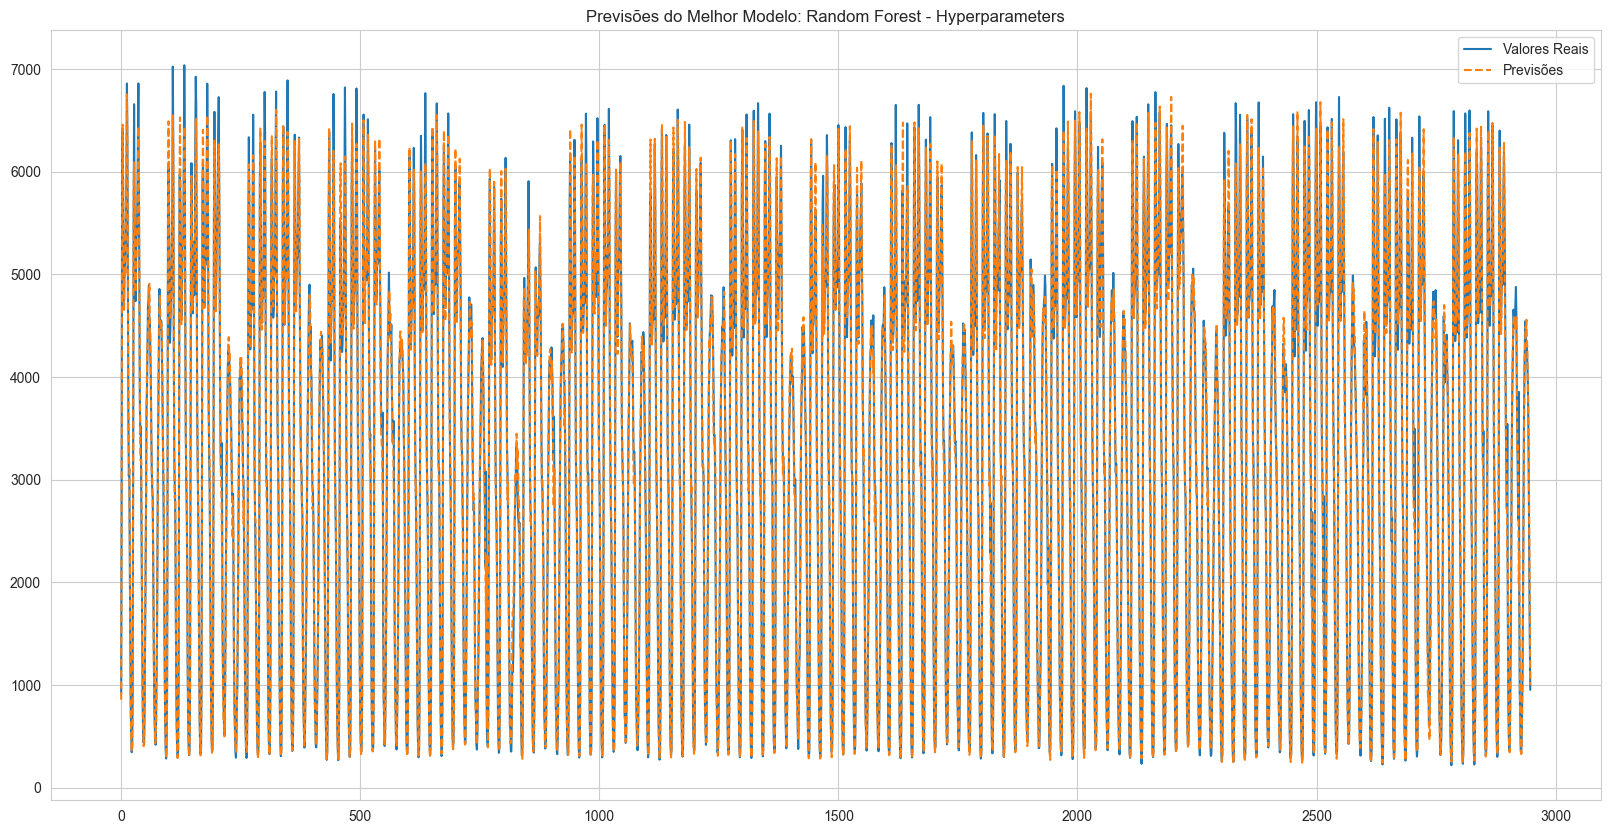

In [132]:
# Previsões do conjunto de teste

name = best_model_df['Model']

name_without_hyperparams = name.replace(' - Hyperparameters', '')

best_model = models_hyper[name_without_hyperparams]
best_model.fit(X_train, y_train.ravel())
y_test_pred = best_model.predict(X_test)

y_test_pred = inverse_transform(y_test_pred, target_min, target_max)
y_test_transformed = inverse_transform(y_test, target_min, target_max)

plt.figure(figsize=(20, 10))
plt.plot(y_test_transformed, label="Valores Reais")
plt.plot(y_test_pred, label="Previsões", linestyle="dashed")
plt.title(f"Previsões do Melhor Modelo: {best_model_df['Model']}")
plt.legend()
plt.show()

As we can see by the graph, the predictions of the Random Forest are very close to the real values. We can conclude that this model is an excellent choice by capturing the underlying patterns of the data due to its ensemble nature, which combines multiple decision trees to reduce variance and improve generalization. This strong performance is further evidenced by the high R² score (0.9870) and low error metrics (MAE and RMSE), both on the validation and test sets.

#### Multi-step forecast

In [133]:
models = {
    "Linear Regression": LinearRegression(),
    "KNeighbors Regressor": KNeighborsRegressor(),
    "Bagging Regressor": BaggingRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
}

In [134]:
WINDOW_IN = 24  
HORIZON = 4  

train_windowed = slideWindow(train_scaled_df[['traffic_volume']], WINDOW_IN, HORIZON)
val_windowed = slideWindow(val_scaled_df[['traffic_volume']], WINDOW_IN, HORIZON)
test_windowed = slideWindow(test_scaled_df[['traffic_volume']], WINDOW_IN, HORIZON)

X_train = train_windowed.iloc[:, :-HORIZON].values 
y_train = train_windowed.iloc[:, -HORIZON:].values  

X_val = val_windowed.iloc[:, :-HORIZON].values
y_val = val_windowed.iloc[:, -HORIZON:].values

X_test = test_windowed.iloc[:, :-HORIZON].values
y_test = test_windowed.iloc[:, -HORIZON:].values

##### Train and evaluate the models

In [135]:

for name, model in models.items():
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)

    y_val_pred = inverse_transform(y_val_pred, target_min, target_max)
    y_val_transformed = inverse_transform(y_val, target_min, target_max)
    
    mae = mean_absolute_error(y_val_transformed, y_val_pred)
    mse = mean_squared_error(y_val_transformed, y_val_pred)
    r2 = r2_score(y_val_transformed, y_val_pred)
    rmse = np.sqrt(mse)

    add_results(results_ml_val, name, HORIZON, mae, mse, r2, rmse)

results_ml_val

Model  Horizon         MAE  \
0                             Linear Regression        1  391.313963   
1                          KNeighbors Regressor        1  202.542111   
2                     Support Vector Regression        1  333.399894   
3                             Bagging Regressor        1  182.430268   
4                             Gradient Boosting        1  207.050198   
5                                 Decision Tree        1  248.049881   
6                                 Random Forest        1  174.955633   
7           Linear Regression - Hyperparameters        1  391.313963   
8        KNeighbors Regressor - Hyperparameters        1  207.989804   
9   Support Vector Regression - Hyperparameters        1  175.083919   
10          Bagging Regressor - Hyperparameters        1  174.331571   
11          Gradient Boosting - Hyperparameters        1  180.089880   
12              Decision Tree - Hyperparameters        1  210.292511   
13              Random Forest - Hyperparameters        1  173.296334   
14                            Linear Regression        4  503.054626   
15                         KNeighbors Regressor        4  255.118128   
16                            Bagging Regressor        4  247.643571   
17                                Decision Tree        4  326.576313   
18                                Random Forest        4  234.225586   

              MSE        R2        RMSE  
0   274802.696198  0.933283  524.216269  
1   103651.230322  0.974835  321.949111  
2   162377.905241  0.960577  402.961419  
3    76589.793831  0.981405  276.748611  
4    94437.700159  0.977072  307.307176  
5   157060.119104  0.961869  396.308111  
6    71723.701765  0.982587  267.812811  
7   274802.696198  0.933283  524.216269  
8   109416.036850  0.973436  330.780950  
9    77108.249044  0.981279  277.683721  
10   71117.716296  0.982734  266.679051  
11   75707.391921  0.981620  275.149763  
12  107460.080227  0.973911  327.811043  
13   71049.717497  0.982750  266.551529  
14  600525.093083  0.854229  774.935541  
15  209678.572364  0.949100  457.906729  
16  173650.795791  0.957847  416.714286  
17  323766.331259  0.921405  569.004685  
18  156024.620232  0.962126  394.999519

In [136]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)

    y_test_pred = inverse_transform(y_test_pred, target_min, target_max)
    y_test_transformed = inverse_transform(y_test, target_min, target_max)
    
    mae = mean_absolute_error(y_test_transformed, y_test_pred)
    mse = mean_squared_error(y_test_transformed, y_test_pred)
    r2 = r2_score(y_test_transformed, y_test_pred)
    rmse = np.sqrt(mse)
    
    add_results(results_ml_test, name, HORIZON, mae, mse, r2, rmse)

results_ml_test

Model  Horizon         MAE  \
0                             Linear Regression        1  348.044764   
1                          KNeighbors Regressor        1  166.298304   
2                     Support Vector Regression        1  279.116834   
3                             Bagging Regressor        1  158.737280   
4                             Gradient Boosting        1  179.708965   
5                                 Decision Tree        1  225.170624   
6                                 Random Forest        1  147.144172   
7           Linear Regression - Hyperparameters        1  348.044764   
8        KNeighbors Regressor - Hyperparameters        1  177.163075   
9   Support Vector Regression - Hyperparameters        1  151.104838   
10          Bagging Regressor - Hyperparameters        1  146.902269   
11          Gradient Boosting - Hyperparameters        1  155.660697   
12              Decision Tree - Hyperparameters        1  182.219335   
13              Random Forest - Hyperparameters        1  146.595491   
14                            Linear Regression        4  439.122484   
15                         KNeighbors Regressor        4  186.812820   
16                            Bagging Regressor        4  184.300972   
17                                Decision Tree        4  262.683004   
18                                Random Forest        4  169.625819   

              MSE        R2        RMSE  
0   228739.996312  0.938877  478.267704  
1    59867.571872  0.984002  244.678507  
2   115475.188998  0.969143  339.816405  
3    55703.599291  0.985115  236.016100  
4    68485.210084  0.981700  261.696790  
5   118952.650271  0.968214  344.895129  
6    48444.585847  0.987055  220.101308  
7   228739.996312  0.938877  478.267704  
8    67571.254604  0.981944  259.944715  
9    49887.643244  0.986669  223.355419  
10   48276.962930  0.987100  219.720192  
11   51616.654735  0.986207  227.192990  
12   79377.434718  0.978789  281.740013  
13   48065.584513  0.987156  219.238647  
14  500850.189678  0.865894  707.707701  
15   86000.333890  0.976976  293.258135  
16   80257.187288  0.978513  283.296995  
17  180507.083617  0.951676  424.861252  
18   66696.401253  0.982144  258.256464

##### Hyperparameters

In [79]:

param_grids = {
    "Linear Regression": {
        "fit_intercept": [True, False]
    },
    "KNeighbors Regressor": {
        "n_neighbors": [3,5],
        "weights": ["uniform", "distance"],
        "algorithm": ["auto", "ball_tree", "kd_tree"],
        "p": [1, 2]
    },
    "Bagging Regressor": {
        "n_estimators": [10, 50, 100],
        "max_samples": [0.5, 0.8, 1.0],
        "bootstrap": [True, False],
        "bootstrap_features": [True, False]
    },
    "Decision Tree": {
        "max_depth": [5, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["squared_error", "friedman_mse"]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    }
}

In [82]:
for model_name, model in models.items():
    param_grid = param_grids[model_name]
    param_combinations = list(product(*param_grid.values()))
    
    best_score = float("inf") 
    best_params = None
    best_model = None
    score_train = None
    
    for combination in param_combinations:
        params = dict(zip(param_grid.keys(), combination))  
        
        model.set_params(**params)
        
        model.fit(X_train, y_train)

        y_val_pred = model.predict(X_val)
        y_train_pred = model.predict(X_train)
        
        mae_val = mean_absolute_error(y_val, y_val_pred)

        if mae_val < best_score:
            best_score = mae_val
            best_params = params
            best_model = model
            score_train = mean_absolute_error(y_train, y_train_pred)
        
    print(f"{model_name}: "
      f"- Score MAE Val = {best_score:.4f}"
      f"- Score MAE Train = {score_train:.4f}"
      f"- Melhores Parâmetros = {best_params}")   

Linear Regression: - Score MAE Val = 0.0671- Score MAE Train = 0.0660- Melhores Parâmetros = {'fit_intercept': False}
KNeighbors Regressor: - Score MAE Val = 0.0340- Score MAE Train = 0.0000- Melhores Parâmetros = {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'kd_tree', 'p': 1}
Bagging Regressor: - Score MAE Val = 0.0323- Score MAE Train = 0.0120- Melhores Parâmetros = {'n_estimators': 100, 'max_samples': 1.0, 'bootstrap': True, 'bootstrap_features': False}
Decision Tree: - Score MAE Val = 0.0389- Score MAE Train = 0.0305- Melhores Parâmetros = {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'criterion': 'squared_error'}
Random Forest: - Score MAE Val = 0.0319- Score MAE Train = 0.0156- Melhores Parâmetros = {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2}


In [137]:
models_hyper = {
    "Linear Regression": LinearRegression(fit_intercept=False),
    "KNeighbors Regressor": KNeighborsRegressor(n_neighbors=5, weights='distance', algorithm='kd_tree', p=1),
    "Bagging Regressor": BaggingRegressor(n_estimators=100, max_samples=1.0, bootstrap=True, bootstrap_features=False),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, min_samples_split=5, min_samples_leaf=2, criterion='squared_error'),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=2),
}

In [138]:
for name, model in models_hyper.items():
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)

    y_val_pred = inverse_transform(y_val_pred, target_min, target_max)
    y_val_transformed = inverse_transform(y_val, target_min, target_max)
    
    mae = mean_absolute_error(y_val_transformed, y_val_pred)
    mse = mean_squared_error(y_val_transformed, y_val_pred)
    r2 = r2_score(y_val_transformed, y_val_pred)
    rmse = np.sqrt(mse)

    add_results(results_ml_val, f"{name} - Hyperparameters", HORIZON, mae, mse, r2, rmse)

results_ml_val

Model  Horizon         MAE  \
0                             Linear Regression        1  391.313963   
1                          KNeighbors Regressor        1  202.542111   
2                     Support Vector Regression        1  333.399894   
3                             Bagging Regressor        1  182.430268   
4                             Gradient Boosting        1  207.050198   
5                                 Decision Tree        1  248.049881   
6                                 Random Forest        1  174.955633   
7           Linear Regression - Hyperparameters        1  391.313963   
8        KNeighbors Regressor - Hyperparameters        1  207.989804   
9   Support Vector Regression - Hyperparameters        1  175.083919   
10          Bagging Regressor - Hyperparameters        1  174.331571   
11          Gradient Boosting - Hyperparameters        1  180.089880   
12              Decision Tree - Hyperparameters        1  210.292511   
13              Random Forest - Hyperparameters        1  173.296334   
14                            Linear Regression        4  503.054626   
15                         KNeighbors Regressor        4  255.118128   
16                            Bagging Regressor        4  247.643571   
17                                Decision Tree        4  326.576313   
18                                Random Forest        4  234.225586   
19          Linear Regression - Hyperparameters        4  488.336469   
20       KNeighbors Regressor - Hyperparameters        4  247.573419   
21          Bagging Regressor - Hyperparameters        4  234.306635   
22              Decision Tree - Hyperparameters        4  284.838090   
23              Random Forest - Hyperparameters        4  231.866432   

              MSE        R2        RMSE  
0   274802.696198  0.933283  524.216269  
1   103651.230322  0.974835  321.949111  
2   162377.905241  0.960577  402.961419  
3    76589.793831  0.981405  276.748611  
4    94437.700159  0.977072  307.307176  
5   157060.119104  0.961869  396.308111  
6    71723.701765  0.982587  267.812811  
7   274802.696198  0.933283  524.216269  
8   109416.036850  0.973436  330.780950  
9    77108.249044  0.981279  277.683721  
10   71117.716296  0.982734  266.679051  
11   75707.391921  0.981620  275.149763  
12  107460.080227  0.973911  327.811043  
13   71049.717497  0.982750  266.551529  
14  600525.093083  0.854229  774.935541  
15  209678.572364  0.949100  457.906729  
16  173650.795791  0.957847  416.714286  
17  323766.331259  0.921405  569.004685  
18  156024.620232  0.962126  394.999519  
19  619593.420204  0.849601  787.142567  
20  198474.419420  0.951819  445.504679  
21  155739.935623  0.962195  394.638994  
22  239344.356779  0.941899  489.228328  
23  154015.127852  0.962613  392.447612

In [139]:

for name, model in models_hyper.items():
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)

    y_test_pred = inverse_transform(y_test_pred, target_min, target_max)
    y_test_transformed = inverse_transform(y_test, target_min, target_max)
    
    mae = mean_absolute_error(y_test_transformed, y_test_pred)
    mse = mean_squared_error(y_test_transformed, y_test_pred)
    r2 = r2_score(y_test_transformed, y_test_pred)
    rmse = np.sqrt(mse)

    add_results(results_ml_test, f"{name} - Hyperparameters", HORIZON, mae, mse, r2, rmse)

results_ml_test

Model  Horizon         MAE  \
0                             Linear Regression        1  348.044764   
1                          KNeighbors Regressor        1  166.298304   
2                     Support Vector Regression        1  279.116834   
3                             Bagging Regressor        1  158.737280   
4                             Gradient Boosting        1  179.708965   
5                                 Decision Tree        1  225.170624   
6                                 Random Forest        1  147.144172   
7           Linear Regression - Hyperparameters        1  348.044764   
8        KNeighbors Regressor - Hyperparameters        1  177.163075   
9   Support Vector Regression - Hyperparameters        1  151.104838   
10          Bagging Regressor - Hyperparameters        1  146.902269   
11          Gradient Boosting - Hyperparameters        1  155.660697   
12              Decision Tree - Hyperparameters        1  182.219335   
13              Random Forest - Hyperparameters        1  146.595491   
14                            Linear Regression        4  439.122484   
15                         KNeighbors Regressor        4  186.812820   
16                            Bagging Regressor        4  184.300972   
17                                Decision Tree        4  262.683004   
18                                Random Forest        4  169.625819   
19          Linear Regression - Hyperparameters        4  426.115078   
20       KNeighbors Regressor - Hyperparameters        4  181.506285   
21          Bagging Regressor - Hyperparameters        4  170.078128   
22              Decision Tree - Hyperparameters        4  220.479976   
23              Random Forest - Hyperparameters        4  169.743012   

              MSE        R2        RMSE  
0   228739.996312  0.938877  478.267704  
1    59867.571872  0.984002  244.678507  
2   115475.188998  0.969143  339.816405  
3    55703.599291  0.985115  236.016100  
4    68485.210084  0.981700  261.696790  
5   118952.650271  0.968214  344.895129  
6    48444.585847  0.987055  220.101308  
7   228739.996312  0.938877  478.267704  
8    67571.254604  0.981944  259.944715  
9    49887.643244  0.986669  223.355419  
10   48276.962930  0.987100  219.720192  
11   51616.654735  0.986207  227.192990  
12   79377.434718  0.978789  281.740013  
13   48065.584513  0.987156  219.238647  
14  500850.189678  0.865894  707.707701  
15   86000.333890  0.976976  293.258135  
16   80257.187288  0.978513  283.296995  
17  180507.083617  0.951676  424.861252  
18   66696.401253  0.982144  258.256464  
19  518613.978426  0.861137  720.148581  
20   82162.560334  0.978003  286.640123  
21   66725.794376  0.982136  258.313365  
22  114065.529164  0.969462  337.735887  
23   66607.426308  0.982167  258.084146

When comparing to previous results we can see that the results drastically got worse. This is due to the use of recursive multi-step forecast strategy used in which the model uses its own past estimated values to make predictions. The accumulation of errors leads to reduced performance as evidenced by the results.

The linear regression performed the worst out of all models just like in the single step forecast.

This time the KNN was the one that performed the best. It's ability to make predictions based on similarity of nearby data points makes it more robust to propagation of errors, despite still being affected.

SVR performed poorly just like time, being one of the worse model we tested.

Bagging Regressor got a good relative score. Its R squared score and errors were close to KNN that had the best results.

Gradient Boosting did not improve relative of the other models, since it was outperformed by many others just like the previous forecast.

Decision Trees managed to get a good comparative R squared score that shows their ability to model non-linear relationships and interactions between features effectively.

Random forest did not get a good performance for this task, being outperformed by KNN, altough both have similar scores and errors.

This results show that these models may not be a suitable option for multi-step forecast using recursion. Since not all are compatible with the direct strategy we chose to only test this approach on the best performing one. When comparing the two different methods we can see a very big difference since the R squared improved drastically. All the errors lowered and we got a performance that is comparable with the results of the single step forecast.

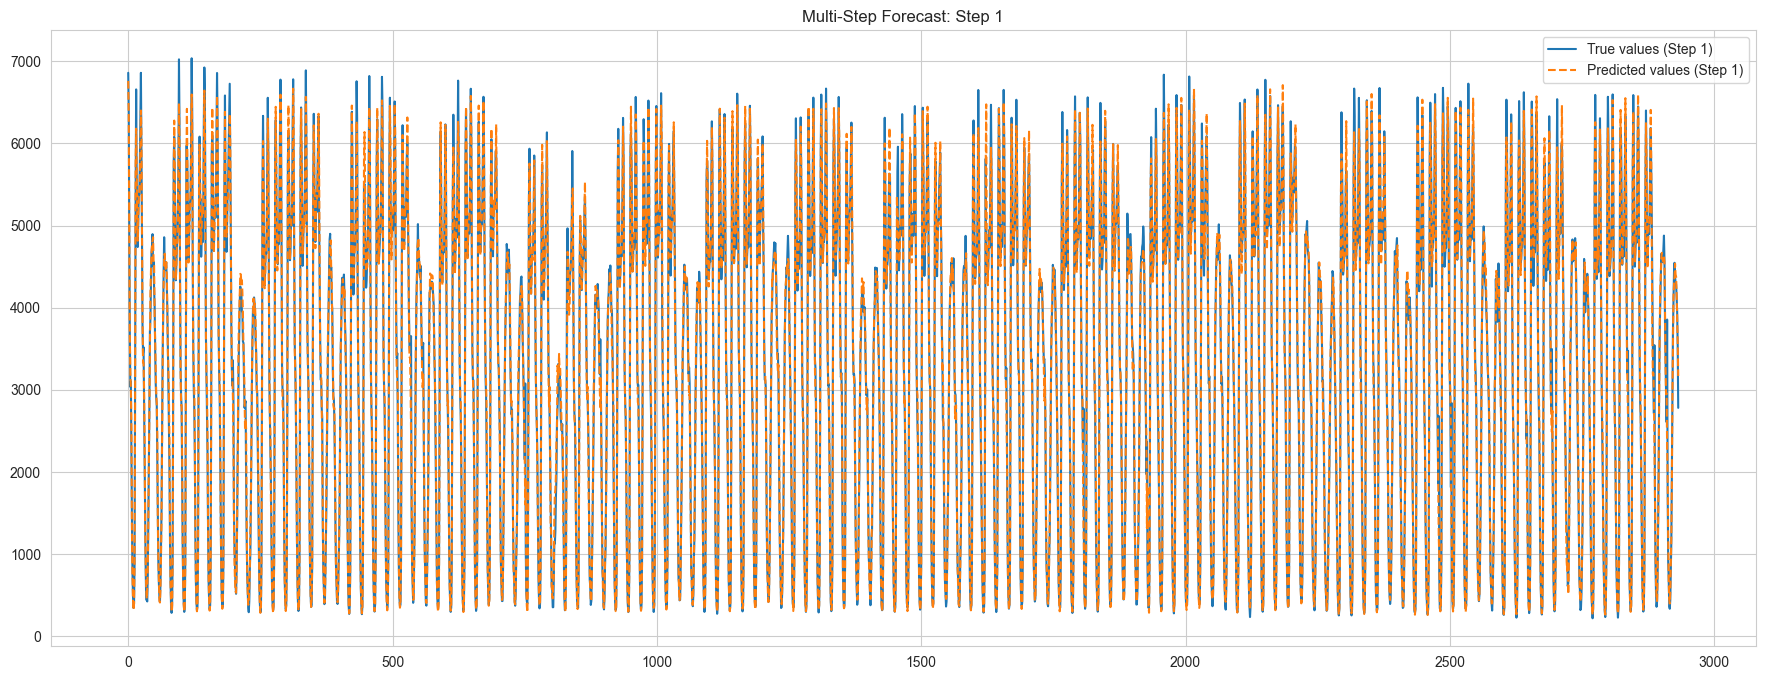

MAE: 137.71641100889207


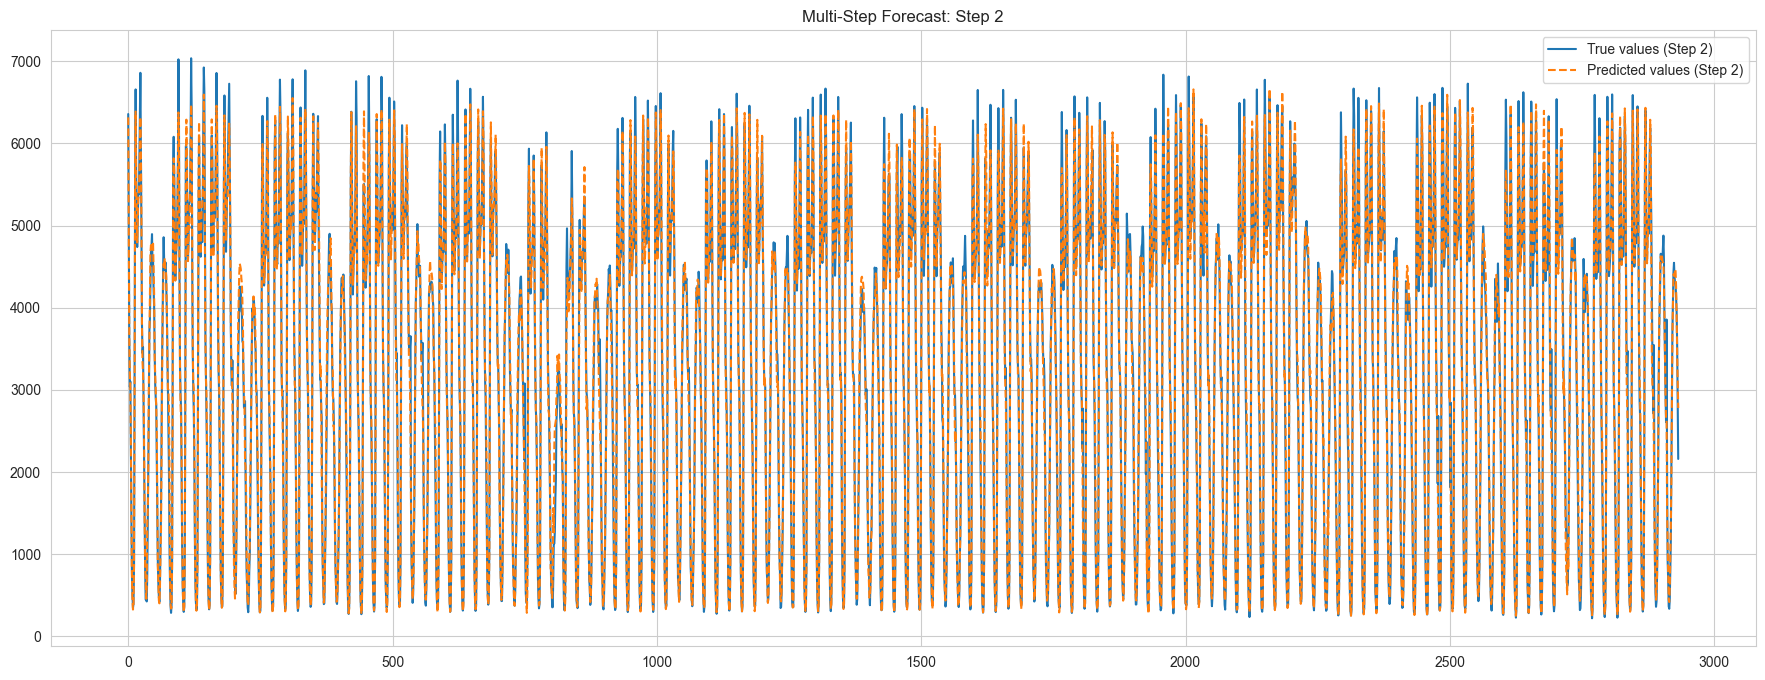

MAE: 165.91200670876077


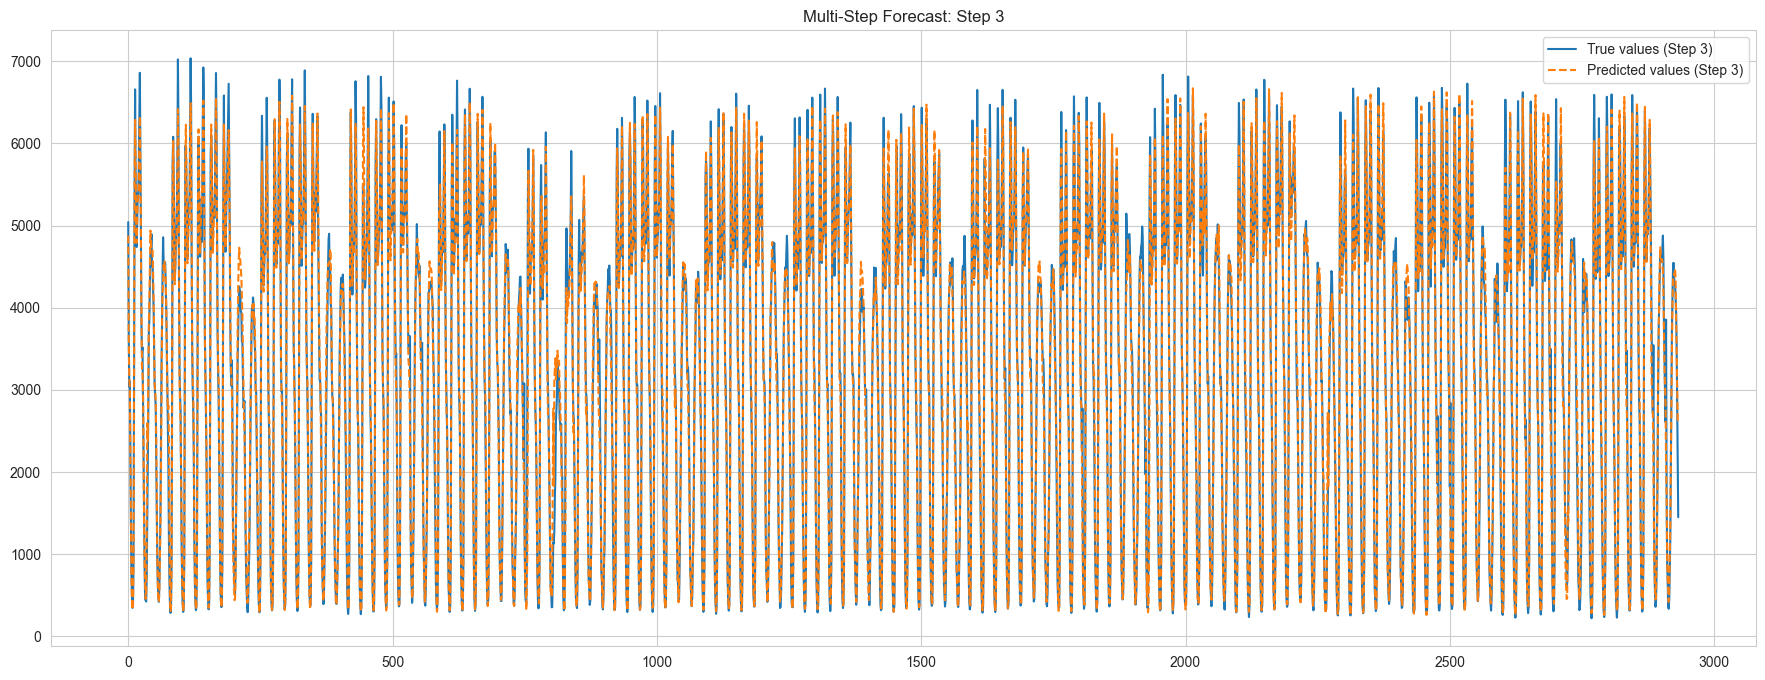

MAE: 180.54087744264572


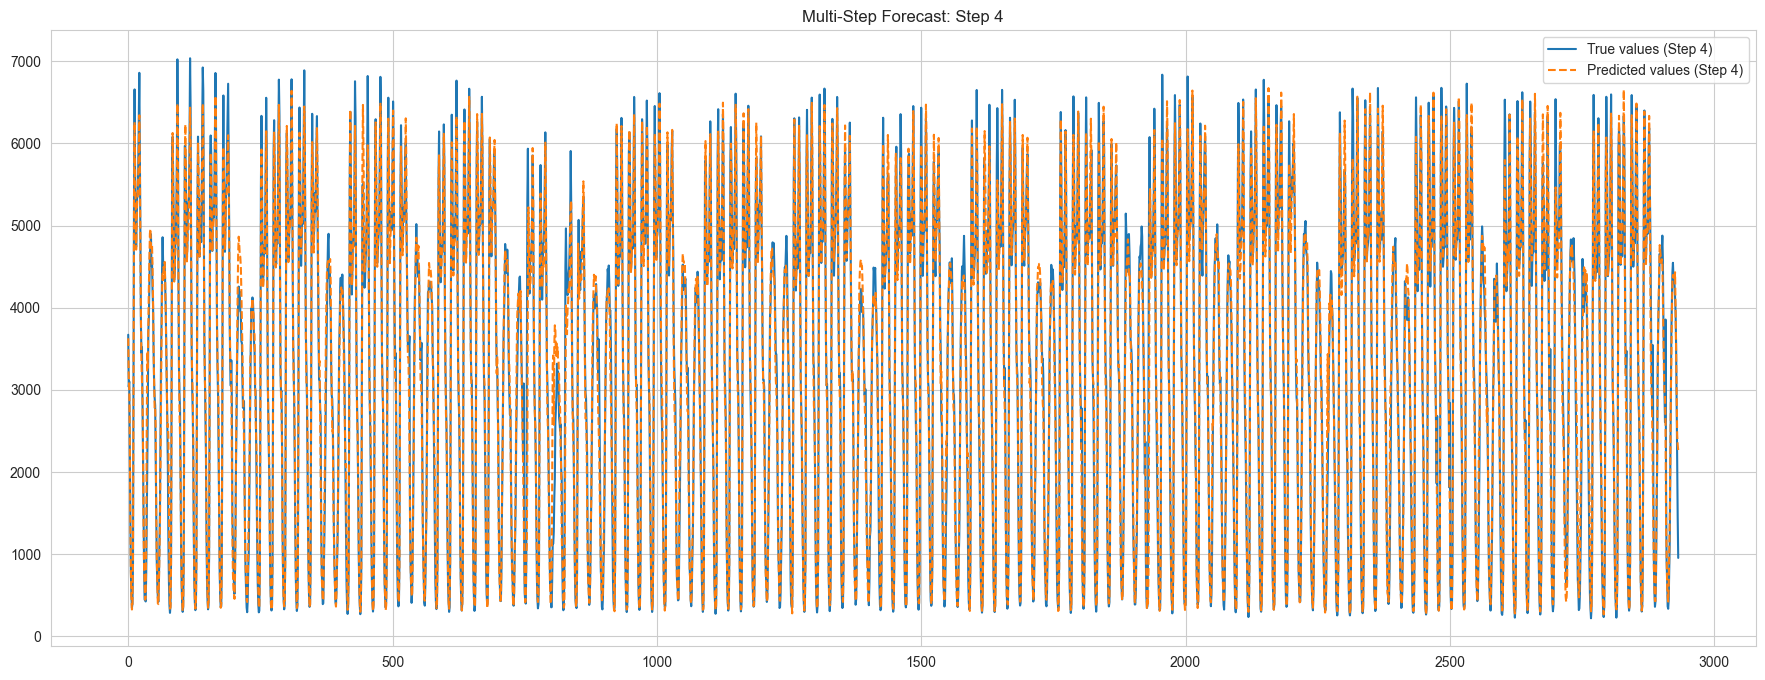

MAE: 193.15395191158612


In [140]:
filtered_results = results_ml_val[
    (results_ml_val['Horizon'] == HORIZON) &
    (results_ml_val['Model'].str.contains('Hyperparameters'))
    ]

best_model_df = filtered_results.loc[filtered_results['MAE'].idxmin()]

name = best_model_df['Model']

name_without_hyperparams = name.replace(' - Hyperparameters', '')

best_model = models_hyper[name_without_hyperparams]
best_model.fit(X_train, y_train)
y_test_pred = best_model.predict(X_test)
y_test_pred = inverse_transform(y_test_pred, target_min, target_max)
y_test_transformed = inverse_transform(y_test, target_min, target_max)

for step in range(HORIZON):
    plt.figure(figsize=(22, 8))
    plt.plot(y_test_transformed[:, step], label=f"True values (Step {step+1})")
    plt.plot(y_test_pred[:, step], label=f"Predicted values (Step {step+1})", linestyle="dashed")
    plt.title(f"Multi-Step Forecast: Step {step+1}")
    plt.legend()
    plt.show()
    print("MAE:",mean_absolute_error(y_test_transformed[:, step], y_test_pred[:, step]))

As we can see from the predictions vs actual values of the traffic volume, the model performed significantly better when using the direct strategy compared to the recursive multi-step forecast strategy. The direct approach trains the model separately for each forecasting horizon, avoiding the accumulation of errors that often occurs in recursive strategies. This results in more accurate and stable predictions for each time step despite the MAE error getting slighly bigger by each horizon step.

### Without Window

#### Define the models

In [141]:
models = {
    "Linear Regression": LinearRegression(),
    "KNeighbors Regressor": KNeighborsRegressor(),
    "Support Vector Regression": SVR(),
    "Bagging Regressor": BaggingRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
}

#### Feature Engineering

In [142]:
def create_features(df):
    df.index = pd.to_datetime(df.index)
    
    df['weekday'] = df.index.weekday  # Day of the week (0 = Monday, 6 = Sunday)
    df['hour'] = df.index.hour        # Hour of the day (0–23)
    
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    
    df['month'] = df.index.month      # Month of the year (1–12)
    df['year'] = df.index.year        # Year (2016, 2017, 2018)
    
    return df

train_scaled_df = create_features(train_scaled_df)
val_scaled_df = create_features(val_scaled_df)
test_scaled_df = create_features(test_scaled_df)

#### Split the data

In [143]:
X_train = train_scaled_df.drop('traffic_volume', axis=1)
y_train = train_scaled_df['traffic_volume']

X_val = val_scaled_df.drop('traffic_volume', axis=1)
y_val = val_scaled_df['traffic_volume']

X_test = test_scaled_df.drop('traffic_volume', axis=1)
y_test = test_scaled_df['traffic_volume']

#### Train and evaluate the models

In [144]:
for name, model in models.items():
    model.fit(X_train, y_train) 
    
    y_val_pred = model.predict(X_val)
    
    y_val_pred = inverse_transform(y_val_pred, target_min, target_max)
    y_val_transformed = inverse_transform(y_val, target_min, target_max)
    
    mae = mean_absolute_error(y_val_transformed, y_val_pred)
    mse = mean_squared_error(y_val_transformed, y_val_pred)
    r2 = r2_score(y_val_transformed, y_val_pred)
    rmse = np.sqrt(mse)
    
    add_results(results_ml_val, f"{name} - No Window", 1, mae, mse, r2, rmse)
    
results_ml_val

Model  Horizon          MAE  \
0                             Linear Regression        1   391.313963   
1                          KNeighbors Regressor        1   202.542111   
2                     Support Vector Regression        1   333.399894   
3                             Bagging Regressor        1   182.430268   
4                             Gradient Boosting        1   207.050198   
5                                 Decision Tree        1   248.049881   
6                                 Random Forest        1   174.955633   
7           Linear Regression - Hyperparameters        1   391.313963   
8        KNeighbors Regressor - Hyperparameters        1   207.989804   
9   Support Vector Regression - Hyperparameters        1   175.083919   
10          Bagging Regressor - Hyperparameters        1   174.331571   
11          Gradient Boosting - Hyperparameters        1   180.089880   
12              Decision Tree - Hyperparameters        1   210.292511   
13              Random Forest - Hyperparameters        1   173.296334   
14                            Linear Regression        4   503.054626   
15                         KNeighbors Regressor        4   255.118128   
16                            Bagging Regressor        4   247.643571   
17                                Decision Tree        4   326.576313   
18                                Random Forest        4   234.225586   
19          Linear Regression - Hyperparameters        4   488.336469   
20       KNeighbors Regressor - Hyperparameters        4   247.573419   
21          Bagging Regressor - Hyperparameters        4   234.306635   
22              Decision Tree - Hyperparameters        4   284.838090   
23              Random Forest - Hyperparameters        4   231.866432   
24                Linear Regression - No Window        1   911.024588   
25             KNeighbors Regressor - No Window        1   307.621967   
26        Support Vector Regression - No Window        1  1703.156071   
27                Bagging Regressor - No Window        1   288.497601   
28                Gradient Boosting - No Window        1   320.834191   
29                    Decision Tree - No Window        1   331.942548   
30                    Random Forest - No Window        1   272.029029   

             MSE        R2         RMSE  
0   2.748027e+05  0.933283   524.216269  
1   1.036512e+05  0.974835   321.949111  
2   1.623779e+05  0.960577   402.961419  
3   7.658979e+04  0.981405   276.748611  
4   9.443770e+04  0.977072   307.307176  
5   1.570601e+05  0.961869   396.308111  
6   7.172370e+04  0.982587   267.812811  
7   2.748027e+05  0.933283   524.216269  
8   1.094160e+05  0.973436   330.780950  
9   7.710825e+04  0.981279   277.683721  
10  7.111772e+04  0.982734   266.679051  
11  7.570739e+04  0.981620   275.149763  
12  1.074601e+05  0.973911   327.811043  
13  7.104972e+04  0.982750   266.551529  
14  6.005251e+05  0.854229   774.935541  
15  2.096786e+05  0.949100   457.906729  
16  1.736508e+05  0.957847   416.714286  
17  3.237663e+05  0.921405   569.004685  
18  1.560246e+05  0.962126   394.999519  
19  6.195934e+05  0.849601   787.142567  
20  1.984744e+05  0.951819   445.504679  
21  1.557399e+05  0.962195   394.638994  
22  2.393444e+05  0.941899   489.228328  
23  1.540151e+05  0.962613   392.447612  
24  1.313453e+06  0.680612  1146.059937  
25  2.733912e+05  0.933520   522.868250  
26  3.651558e+06  0.112064  1910.905104  
27  2.220479e+05  0.946005   471.219539  
28  2.157007e+05  0.947549   464.435846  
29  2.997834e+05  0.927103   547.524775  
30  2.000183e+05  0.951362   447.234062

In [145]:
for name, model in models.items():
    model.fit(X_train, y_train) 
    y_test_pred = model.predict(X_test) 

    y_test_pred = inverse_transform(y_test_pred, target_min, target_max)
    y_test_transformed = inverse_transform(y_test, target_min, target_max)
    
    mae = mean_absolute_error(y_test_transformed, y_test_pred)
    mse = mean_squared_error(y_test_transformed, y_test_pred)
    r2 = r2_score(y_test_transformed, y_test_pred)
    rmse = np.sqrt(mse)
    
    add_results(results_ml_test, f"{name} - No Window", 1, mae, mse, r2, rmse)
    
results_ml_test

Model  Horizon          MAE  \
0                             Linear Regression        1   348.044764   
1                          KNeighbors Regressor        1   166.298304   
2                     Support Vector Regression        1   279.116834   
3                             Bagging Regressor        1   158.737280   
4                             Gradient Boosting        1   179.708965   
5                                 Decision Tree        1   225.170624   
6                                 Random Forest        1   147.144172   
7           Linear Regression - Hyperparameters        1   348.044764   
8        KNeighbors Regressor - Hyperparameters        1   177.163075   
9   Support Vector Regression - Hyperparameters        1   151.104838   
10          Bagging Regressor - Hyperparameters        1   146.902269   
11          Gradient Boosting - Hyperparameters        1   155.660697   
12              Decision Tree - Hyperparameters        1   182.219335   
13              Random Forest - Hyperparameters        1   146.595491   
14                            Linear Regression        4   439.122484   
15                         KNeighbors Regressor        4   186.812820   
16                            Bagging Regressor        4   184.300972   
17                                Decision Tree        4   262.683004   
18                                Random Forest        4   169.625819   
19          Linear Regression - Hyperparameters        4   426.115078   
20       KNeighbors Regressor - Hyperparameters        4   181.506285   
21          Bagging Regressor - Hyperparameters        4   170.078128   
22              Decision Tree - Hyperparameters        4   220.479976   
23              Random Forest - Hyperparameters        4   169.743012   
24                Linear Regression - No Window        1   861.132348   
25             KNeighbors Regressor - No Window        1   233.973986   
26        Support Vector Regression - No Window        1  1607.431227   
27                Bagging Regressor - No Window        1   214.595372   
28                Gradient Boosting - No Window        1   246.104002   
29                    Decision Tree - No Window        1   276.690541   
30                    Random Forest - No Window        1   209.406753   

             MSE        R2         RMSE  
0   2.287400e+05  0.938877   478.267704  
1   5.986757e+04  0.984002   244.678507  
2   1.154752e+05  0.969143   339.816405  
3   5.570360e+04  0.985115   236.016100  
4   6.848521e+04  0.981700   261.696790  
5   1.189527e+05  0.968214   344.895129  
6   4.844459e+04  0.987055   220.101308  
7   2.287400e+05  0.938877   478.267704  
8   6.757125e+04  0.981944   259.944715  
9   4.988764e+04  0.986669   223.355419  
10  4.827696e+04  0.987100   219.720192  
11  5.161665e+04  0.986207   227.192990  
12  7.937743e+04  0.978789   281.740013  
13  4.806558e+04  0.987156   219.238647  
14  5.008502e+05  0.865894   707.707701  
15  8.600033e+04  0.976976   293.258135  
16  8.025719e+04  0.978513   283.296995  
17  1.805071e+05  0.951676   424.861252  
18  6.669640e+04  0.982144   258.256464  
19  5.186140e+05  0.861137   720.148581  
20  8.216256e+04  0.978003   286.640123  
21  6.672579e+04  0.982136   258.313365  
22  1.140655e+05  0.969462   337.735887  
23  6.660743e+04  0.982167   258.084146  
24  1.125436e+06  0.699846  1060.865576  
25  1.496602e+05  0.960086   386.859398  
26  3.292104e+06  0.121995  1814.415581  
27  9.833070e+04  0.973775   313.577267  
28  1.110397e+05  0.970386   333.226264  
29  1.965936e+05  0.947568   443.388751  
30  9.557704e+04  0.974510   309.155370

In [103]:
param_grids = {
    "Linear Regression": {
        "fit_intercept": [True, False]
    },
    "KNeighbors Regressor": {
        "n_neighbors": [3],
        "weights": ["uniform", "distance"],
        "algorithm": ["auto", "ball_tree", "kd_tree"],
        "p": [1, 2]  
    },
    "Support Vector Regression": {
        "C": [0.1, 1, 10],
        "epsilon": [0.01, 0.1, 0.5],
        "kernel": ["linear", "rbf"],
        "gamma": ["scale", "auto"]
    },
    "Bagging Regressor": {
        "n_estimators": [10, 50, 100],
        "max_samples": [0.5, 0.8, 1.0],
        "bootstrap": [True, False],
        "bootstrap_features": [True, False]
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 10],
        "subsample": [0.8, 1.0]
    },
    "Decision Tree": {
        "max_depth": [5, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["squared_error", "friedman_mse"]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    }
}

In [104]:
for model_name, model in models.items():
    param_grid = param_grids[model_name]
    param_combinations = list(product(*param_grid.values()))
    
    best_score = float("inf") 
    best_params = None
    best_model = None
    score_train = None
    
    for combination in param_combinations:
        params = dict(zip(param_grid.keys(), combination))  
        
        model.set_params(**params)
        
        model.fit(X_train, y_train)

        y_val_pred = model.predict(X_val)
        y_train_pred = model.predict(X_train)
        
        mae_val = mean_absolute_error(y_val, y_val_pred)

        if mae_val < best_score:
            best_score = mae_val
            best_params = params
            best_model = model
            score_train = mean_absolute_error(y_train, y_train_pred)
        
    print(f"{model_name}: "
      f"- Score MAE Val = {best_score:.4f}"
      f"- Score MAE Train = {score_train:.4f}"
      f"- Melhores Parâmetros = {best_params}")   

Linear Regression: - Score MAE Val = 0.1202- Score MAE Train = 0.1156- Melhores Parâmetros = {'fit_intercept': False}
KNeighbors Regressor: - Score MAE Val = 0.0421- Score MAE Train = 0.0296- Melhores Parâmetros = {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'auto', 'p': 2}
Support Vector Regression: - Score MAE Val = 0.0486- Score MAE Train = 0.0372- Melhores Parâmetros = {'C': 0.1, 'epsilon': 0.01, 'kernel': 'rbf', 'gamma': 'auto'}
Bagging Regressor: - Score MAE Val = 0.0370- Score MAE Train = 0.0162- Melhores Parâmetros = {'n_estimators': 50, 'max_samples': 0.5, 'bootstrap': False, 'bootstrap_features': False}
Gradient Boosting: - Score MAE Val = 0.0362- Score MAE Train = 0.0300- Melhores Parâmetros = {'n_estimators': 50, 'learning_rate': 0.2, 'max_depth': 5, 'subsample': 1.0}
Decision Tree: - Score MAE Val = 0.0407- Score MAE Train = 0.0212- Melhores Parâmetros = {'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 2, 'criterion': 'friedman_mse'}
Random Forest: -

In [146]:
models_hyper = {
    "Linear Regression": LinearRegression(fit_intercept=False),
    "KNeighbors Regressor": KNeighborsRegressor(n_neighbors=3, weights='uniform', algorithm='auto', p=2),
    "Support Vector Regression": SVR(C=0.1, epsilon=0.01, kernel='rbf', gamma='auto'),
    "Bagging Regressor": BaggingRegressor(n_estimators=50, max_samples=0.5, bootstrap=False, bootstrap_features=False),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=50, learning_rate=0.2, max_depth=5, subsample=1.0),
    "Decision Tree": DecisionTreeRegressor(max_depth=20, min_samples_split=10, min_samples_leaf=2, criterion='friedman_mse'),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=10, min_samples_leaf=4),
}

In [147]:
for name, model in models_hyper.items():
    model.fit(X_train, y_train) 
    
    y_val_pred = model.predict(X_val)
    
    y_val_pred = inverse_transform(y_val_pred, target_min, target_max)
    y_val_transformed = inverse_transform(y_val, target_min, target_max)
    
    mae = mean_absolute_error(y_val_transformed, y_val_pred)
    mse = mean_squared_error(y_val_transformed, y_val_pred)
    r2 = r2_score(y_val_transformed, y_val_pred)
    rmse = np.sqrt(mse)
    
    add_results(results_ml_val, f"{name} - No Window and Hyperparameters", 1, mae, mse, r2, rmse)
    
results_ml_val

Model  Horizon          MAE  \
0                                   Linear Regression        1   391.313963   
1                                KNeighbors Regressor        1   202.542111   
2                           Support Vector Regression        1   333.399894   
3                                   Bagging Regressor        1   182.430268   
4                                   Gradient Boosting        1   207.050198   
5                                       Decision Tree        1   248.049881   
6                                       Random Forest        1   174.955633   
7                 Linear Regression - Hyperparameters        1   391.313963   
8              KNeighbors Regressor - Hyperparameters        1   207.989804   
9         Support Vector Regression - Hyperparameters        1   175.083919   
10                Bagging Regressor - Hyperparameters        1   174.331571   
11                Gradient Boosting - Hyperparameters        1   180.089880   
12                    Decision Tree - Hyperparameters        1   210.292511   
13                    Random Forest - Hyperparameters        1   173.296334   
14                                  Linear Regression        4   503.054626   
15                               KNeighbors Regressor        4   255.118128   
16                                  Bagging Regressor        4   247.643571   
17                                      Decision Tree        4   326.576313   
18                                      Random Forest        4   234.225586   
19                Linear Regression - Hyperparameters        4   488.336469   
20             KNeighbors Regressor - Hyperparameters        4   247.573419   
21                Bagging Regressor - Hyperparameters        4   234.306635   
22                    Decision Tree - Hyperparameters        4   284.838090   
23                    Random Forest - Hyperparameters        4   231.866432   
24                      Linear Regression - No Window        1   911.024588   
25                   KNeighbors Regressor - No Window        1   307.621967   
26              Support Vector Regression - No Window        1  1703.156071   
27                      Bagging Regressor - No Window        1   288.497601   
28                      Gradient Boosting - No Window        1   320.834191   
29                          Decision Tree - No Window        1   331.942548   
30                          Random Forest - No Window        1   272.029029   
31  Linear Regression - No Window and Hyperparameters        1   875.042000   
32  KNeighbors Regressor - No Window and Hyperpara...        1   306.773347   
33  Support Vector Regression - No Window and Hype...        1   353.665996   
34  Bagging Regressor - No Window and Hyperparameters        1   270.794877   
35  Gradient Boosting - No Window and Hyperparameters        1   263.070694   
36      Decision Tree - No Window and Hyperparameters        1   295.347319   
37      Random Forest - No Window and Hyperparameters        1   263.707466   

             MSE        R2         RMSE  
0   2.748027e+05  0.933283   524.216269  
1   1.036512e+05  0.974835   321.949111  
2   1.623779e+05  0.960577   402.961419  
3   7.658979e+04  0.981405   276.748611  
4   9.443770e+04  0.977072   307.307176  
5   1.570601e+05  0.961869   396.308111  
6   7.172370e+04  0.982587   267.812811  
7   2.748027e+05  0.933283   524.216269  
8   1.094160e+05  0.973436   330.780950  
9   7.710825e+04  0.981279   277.683721  
10  7.111772e+04  0.982734   266.679051  
11  7.570739e+04  0.981620   275.149763  
12  1.074601e+05  0.973911   327.811043  
13  7.104972e+04  0.982750   266.551529  
14  6.005251e+05  0.854229   774.935541  
15  2.096786e+05  0.949100   457.906729  
16  1.736508e+05  0.957847   416.714286  
17  3.237663e+05  0.921405   569.004685  
18  1.560246e+05  0.962126   394.999519  
19  6.195934e+05  0.849601   787.142567  
20  1.984744e+05  0.951819   445.504679  
21  1.557399e+05  0.962195   394.638994  


In [148]:
for name, model in models_hyper.items():
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)

    y_test_pred = inverse_transform(y_test_pred, target_min, target_max)
    y_test_transformed = inverse_transform(y_test, target_min, target_max)
    
    mae = mean_absolute_error(y_test_transformed, y_test_pred)
    mse = mean_squared_error(y_test_transformed, y_test_pred)
    r2 = r2_score(y_test_transformed, y_test_pred)
    rmse = np.sqrt(mse)

    add_results(results_ml_test, f"{name} - No Window and Hyperparameters", 1, mae, mse, r2, rmse)
    
results_ml_test

Model  Horizon          MAE  \
0                                   Linear Regression        1   348.044764   
1                                KNeighbors Regressor        1   166.298304   
2                           Support Vector Regression        1   279.116834   
3                                   Bagging Regressor        1   158.737280   
4                                   Gradient Boosting        1   179.708965   
5                                       Decision Tree        1   225.170624   
6                                       Random Forest        1   147.144172   
7                 Linear Regression - Hyperparameters        1   348.044764   
8              KNeighbors Regressor - Hyperparameters        1   177.163075   
9         Support Vector Regression - Hyperparameters        1   151.104838   
10                Bagging Regressor - Hyperparameters        1   146.902269   
11                Gradient Boosting - Hyperparameters        1   155.660697   
12                    Decision Tree - Hyperparameters        1   182.219335   
13                    Random Forest - Hyperparameters        1   146.595491   
14                                  Linear Regression        4   439.122484   
15                               KNeighbors Regressor        4   186.812820   
16                                  Bagging Regressor        4   184.300972   
17                                      Decision Tree        4   262.683004   
18                                      Random Forest        4   169.625819   
19                Linear Regression - Hyperparameters        4   426.115078   
20             KNeighbors Regressor - Hyperparameters        4   181.506285   
21                Bagging Regressor - Hyperparameters        4   170.078128   
22                    Decision Tree - Hyperparameters        4   220.479976   
23                    Random Forest - Hyperparameters        4   169.743012   
24                      Linear Regression - No Window        1   861.132348   
25                   KNeighbors Regressor - No Window        1   233.973986   
26              Support Vector Regression - No Window        1  1607.431227   
27                      Bagging Regressor - No Window        1   214.595372   
28                      Gradient Boosting - No Window        1   246.104002   
29                          Decision Tree - No Window        1   276.690541   
30                          Random Forest - No Window        1   209.406753   
31  Linear Regression - No Window and Hyperparameters        1   794.271165   
32  KNeighbors Regressor - No Window and Hyperpara...        1   240.638626   
33  Support Vector Regression - No Window and Hype...        1   336.239901   
34  Bagging Regressor - No Window and Hyperparameters        1   207.467453   
35  Gradient Boosting - No Window and Hyperparameters        1   203.050249   
36      Decision Tree - No Window and Hyperparameters        1   236.972497   
37      Random Forest - No Window and Hyperparameters        1   192.534591   

             MSE        R2         RMSE  
0   2.287400e+05  0.938877   478.267704  
1   5.986757e+04  0.984002   244.678507  
2   1.154752e+05  0.969143   339.816405  
3   5.570360e+04  0.985115   236.016100  
4   6.848521e+04  0.981700   261.696790  
5   1.189527e+05  0.968214   344.895129  
6   4.844459e+04  0.987055   220.101308  
7   2.287400e+05  0.938877   478.267704  
8   6.757125e+04  0.981944   259.944715  
9   4.988764e+04  0.986669   223.355419  
10  4.827696e+04  0.987100   219.720192  
11  5.161665e+04  0.986207   227.192990  
12  7.937743e+04  0.978789   281.740013  
13  4.806558e+04  0.987156   219.238647  
14  5.008502e+05  0.865894   707.707701  
15  8.600033e+04  0.976976   293.258135  
16  8.025719e+04  0.978513   283.296995  
17  1.805071e+05  0.951676   424.861252  
18  6.669640e+04  0.982144   258.256464  
19  5.186140e+05  0.861137   720.148581  
20  8.216256e+04  0.978003   286.640123  
21  6.672579e+04  0.982136   258.313365  


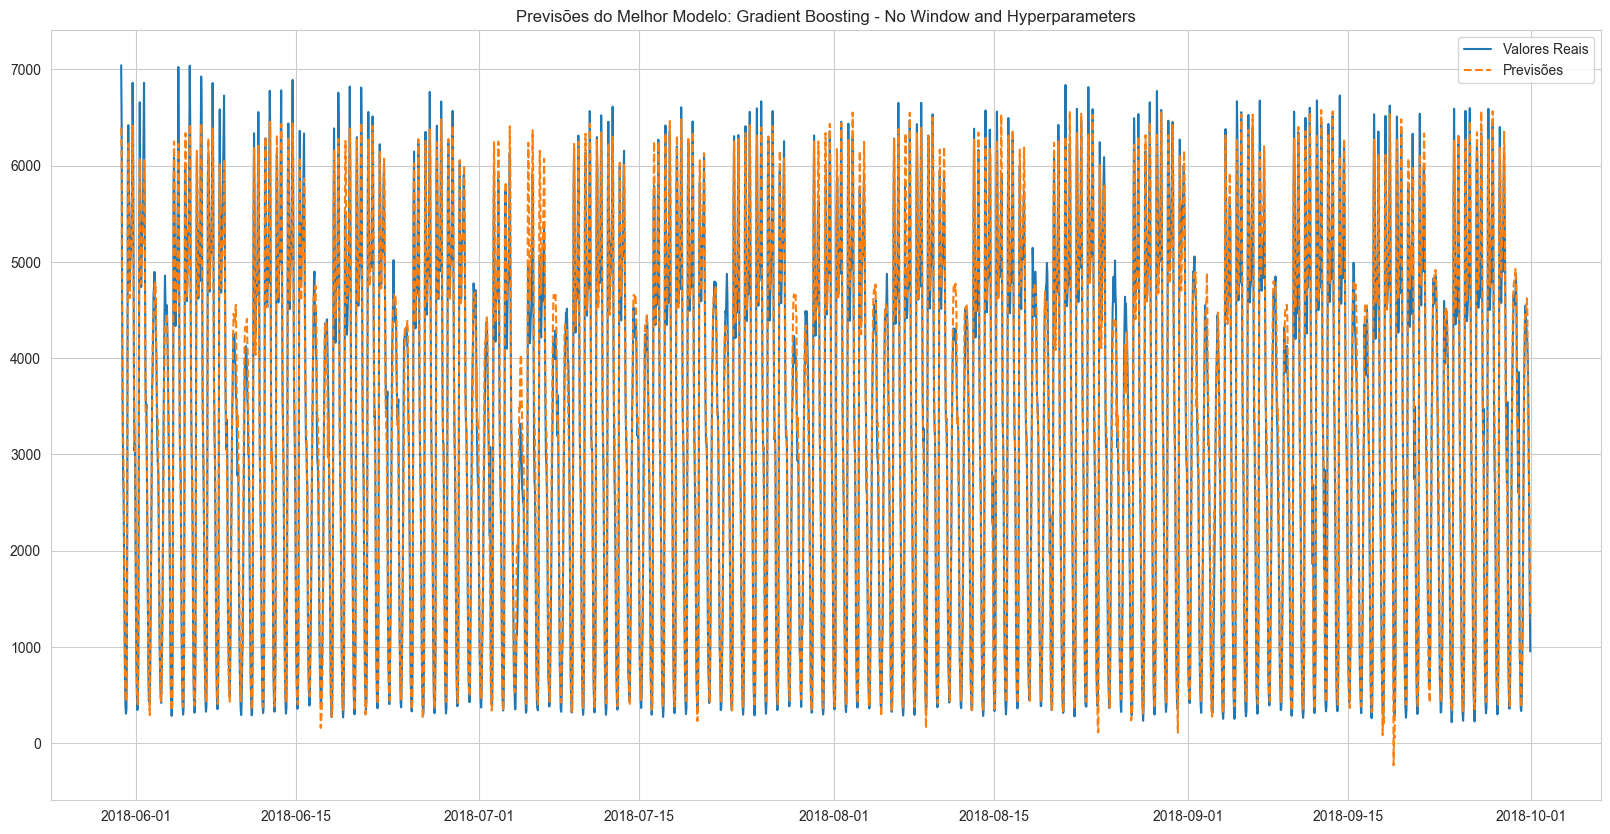

In [151]:
# Previsões do conjunto de teste
filtered_results = results_ml_val[
    (results_ml_val['Horizon'] == 1) & 
    (results_ml_val['Model'].str.contains('- No Window and Hyperparameters')) 
]

best_model_df = filtered_results.loc[filtered_results['MAE'].idxmin()]

name = best_model_df['Model']

name_without_hyperparams = name.replace(' - No Window and Hyperparameters', '')

best_model = models_hyper[name_without_hyperparams]
best_model.fit(X_train, y_train)
y_test_pred = best_model.predict(X_test)

y_test_pred = inverse_transform(y_test_pred, target_min, target_max)
y_test_transformed = inverse_transform(y_test, target_min, target_max)
y_test_pred = pd.Series(y_test_pred, index=y_test.index)

plt.figure(figsize=(20, 10))
plt.plot(y_test_transformed, label="Valores Reais")
plt.plot(y_test_pred, label="Previsões", linestyle="dashed")
plt.title(f"Previsões do Melhor Modelo: {best_model_df['Model']}")
plt.legend()
plt.show()

### Deep learning models

#### LSTM